# RAG Strategy Analysis: What Makes RAG More Performatic?

This notebook analyzes the RAG experiment results to understand:
1. **RAG vs Direct LLM**: When does RAG help vs hurt?
2. **Component Impact**: How do HyDE, reranking, top_k, etc. affect performance?
3. **Best Configurations**: What combinations work best for each model?
4. **Feature Importance**: Which factors matter most?

In [120]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any
import re

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

STUDY_PATH = Path("../outputs/rag_strategies_test")

## 1. Load and Parse Results

In [121]:
def parse_experiment_name(name: str) -> Dict[str, Any]:
    """Parse experiment name to extract configuration."""
    config = {
        'name': name,
        'exp_type': 'direct' if name.startswith('direct_') else 'rag',
        'model': None,
        'retriever_type': None,
        'retriever_name': None,
        'top_k': None,
        'query_transform': None,
        'reranker': None,
        'prompt_style': None,
        'dataset': None,
    }
    
    # Extract model
    if 'metallama_Llama3.23BInstruct' in name:
        config['model'] = 'Llama-3.2-3B'
    elif 'google_gemma2bit' in name:
        config['model'] = 'Gemma-2B'
    elif 'Qwen_Qwen2.51.5BInstruct' in name:
        config['model'] = 'Qwen-1.5B'
    
    # Extract retriever type and name
    if 'dense_bge_large' in name:
        config['retriever_type'] = 'dense'
        config['retriever_name'] = 'bge_large'
    elif 'dense_e5_large' in name:
        config['retriever_type'] = 'dense'
        config['retriever_name'] = 'e5_large'
    elif 'dense_gte_large' in name:
        config['retriever_type'] = 'dense'
        config['retriever_name'] = 'gte_large'
    elif 'hybrid_bge_dense_heavy' in name:
        config['retriever_type'] = 'hybrid'
        config['retriever_name'] = 'bge_dense_heavy'
    elif 'hybrid_bge' in name:
        config['retriever_type'] = 'hybrid'
        config['retriever_name'] = 'bge'
    elif 'hierarchical_bge' in name:
        config['retriever_type'] = 'hierarchical'
        config['retriever_name'] = 'bge'
    
    # Extract top_k
    k_match = re.search(r'_k(\d+)_', name)
    if k_match:
        config['top_k'] = int(k_match.group(1))
    
    # Extract query transform
    if '_hyde_' in name:
        config['query_transform'] = 'hyde'
    elif '_multiquery_' in name:
        config['query_transform'] = 'multiquery'
    else:
        config['query_transform'] = 'none'
    
    # Extract reranker
    if '_rerank_bge_' in name:
        config['reranker'] = 'bge'
    elif '_rerank_ms_marco_' in name:
        config['reranker'] = 'ms_marco'
    else:
        config['reranker'] = 'none'
    
    # Extract prompt style
    if '_concise_' in name:
        config['prompt_style'] = 'concise'
    elif '_fewshot_' in name:
        config['prompt_style'] = 'fewshot'
    elif '_default_' in name:
        config['prompt_style'] = 'default'
    
    # Extract dataset
    if '_nq_' in name:
        config['dataset'] = 'nq'
    elif '_hotpotqa_' in name:
        config['dataset'] = 'hotpotqa'
    
    return config

def load_all_results(study_path: Path) -> pd.DataFrame:
    """Load all experiment results into a DataFrame."""
    results = []
    
    # Directories to skip (deprecated / archived experiments)
    _SKIP = {'_archived_fake_reranked', '_tainted', '_collisions', '_incomplete',
             'analysis', '__pycache__', '.ipynb_checkpoints'}
    
    for exp_dir in study_path.iterdir():
        if not exp_dir.is_dir():
            continue
        if exp_dir.name in _SKIP or exp_dir.name.startswith('_') or exp_dir.name.startswith('.'):
            continue
        
        # Skip incomplete / failed experiments
        state_file = exp_dir / "state.json"
        if state_file.exists():
            try:
                with open(state_file) as f:
                    state = json.load(f)
                phase = state.get('phase', '')
                if phase in ('failed', 'generating', 'init', 'computing_metrics'):
                    continue
            except (json.JSONDecodeError, OSError):
                pass
        
        results_file = exp_dir / "results.json"
        if not results_file.exists():
            continue
        
        try:
            with open(results_file) as f:
                data = json.load(f)
            
            # Parse experiment name
            config = parse_experiment_name(data['name'])
            
            # Add metrics
            metrics = data.get('metrics', {})
            config.update({
                'f1': metrics.get('f1', None),
                'exact_match': metrics.get('exact_match', None),
                'bertscore_f1': metrics.get('bertscore_f1', None),
                'llm_judge_qa': metrics.get('llm_judge_qa', None),
                'duration': data.get('duration_seconds', None),
                'num_examples': data.get('num_examples', None),
            })
            
            results.append(config)
        except Exception as e:
            print(f"Error loading {exp_dir.name}: {e}")
    
    return pd.DataFrame(results)

In [122]:
# Load all results
df = load_all_results(STUDY_PATH)
print(f"Loaded {len(df)} experiments")

# Filter to completed experiments with metrics
df = df[df['f1'].notna()]
print(f"Experiments with metrics: {len(df)}")

df.head()

Loaded 392 experiments
Experiments with metrics: 391


,name,exp_type,model,retriever_type,retriever_name,top_k,query_transform,reranker,prompt_style,dataset,f1,exact_match,bertscore_f1,llm_judge_qa,duration,num_examples
0,rag_hf_metallama_Llama3.23BInstruct_hybrid_bge...,rag,Llama-3.2-3B,hybrid,bge,5.0,none,none,concise,nq,0.088106,0.05,0.463118,0.00,179.065672,100.0
1,rag_hf_google_gemma2bit_dense_bge_large_k10_hy...,rag,Gemma-2B,dense,bge_large,10.0,hyde,bge,fewshot,nq,0.054414,0.02,0.462432,0.03,192.826429,100.0
2,rag_hf_google_gemma2bit_hybrid_bge_k5_rerank_m...,rag,Gemma-2B,hybrid,bge,5.0,none,ms_marco,fewshot,nq,0.129592,0.07,0.519584,0.13,181.992596,100.0
3,rag_hf_metallama_Llama3.23BInstruct_dense_bge_...,rag,Llama-3.2-3B,dense,bge_large,3.0,hyde,bge,fewshot,nq,0.183192,0.11,0.518797,0.35,756.468219,100.0
4,rag_hf_google_gemma2bit_hierarchical_bge_2048_...,rag,Gemma-2B,hierarchical,bge,5.0,none,none,concise,nq,0.097778,0.03,0.476622,0.12,177.533505,100.0


In [123]:
# Summary statistics
print("\n=== Dataset Summary ===")
print(f"Models: {df['model'].unique()}")
print(f"Retriever types: {df['retriever_type'].dropna().unique()}")
print(f"Query transforms: {df['query_transform'].dropna().unique()}")
print(f"Rerankers: {df['reranker'].dropna().unique()}")
print(f"Datasets: {df['dataset'].unique()}")
print(f"Top-k values: {sorted(df['top_k'].dropna().unique())}")


=== Dataset Summary ===
Models: ['Llama-3.2-3B' 'Gemma-2B' 'Qwen-1.5B']
Retriever types: ['hybrid' 'dense' 'hierarchical']
Query transforms: ['none' 'hyde' 'multiquery']
Rerankers: ['none' 'bge' 'ms_marco']
Datasets: ['nq' 'hotpotqa']
Top-k values: [3.0, 5.0, 10.0]


## 2. RAG vs Direct LLM Baseline

First, let's understand when RAG helps vs. hurts compared to the direct LLM baseline.

In [124]:
# Separate direct and RAG experiments
direct_df = df[df['exp_type'] == 'direct'].copy()
rag_df = df[df['exp_type'] == 'rag'].copy()

print(f"Direct experiments: {len(direct_df)}")
print(f"RAG experiments: {len(rag_df)}")

Direct experiments: 5
RAG experiments: 386


In [125]:
# Get baseline performance for each model + dataset + prompt_style combo
baselines = direct_df.groupby(['model', 'dataset', 'prompt_style']).agg({
    'f1': 'mean',
    'exact_match': 'mean',
    'bertscore_f1': 'mean',
}).reset_index()
baselines.columns = ['model', 'dataset', 'prompt_style', 'baseline_f1', 'baseline_em', 'baseline_bertscore']

print("Baseline (Direct LLM) Performance:")
baselines

Baseline (Direct LLM) Performance:


,model,dataset,prompt_style,baseline_f1,baseline_em,baseline_bertscore
0,Gemma-2B,hotpotqa,concise,0.050939,0.00,0.469337
1,Gemma-2B,nq,concise,0.057504,0.01,0.471885
2,Llama-3.2-3B,hotpotqa,concise,0.164044,0.12,0.546201
3,Llama-3.2-3B,nq,concise,0.267985,0.17,0.556321
4,Qwen-1.5B,hotpotqa,concise,0.107689,0.04,0.461733


In [126]:
# Merge baselines with RAG results to compute improvement
rag_with_baseline = rag_df.merge(
    baselines,
    on=['model', 'dataset', 'prompt_style'],
    how='left'
)

# Calculate improvement over baseline
rag_with_baseline['f1_improvement'] = rag_with_baseline['f1'] - rag_with_baseline['baseline_f1']
rag_with_baseline['em_improvement'] = rag_with_baseline['exact_match'] - rag_with_baseline['baseline_em']
rag_with_baseline['bertscore_improvement'] = rag_with_baseline['bertscore_f1'] - rag_with_baseline['baseline_bertscore']

# Relative improvement
rag_with_baseline['f1_relative_improvement'] = (
    (rag_with_baseline['f1'] - rag_with_baseline['baseline_f1']) / 
    rag_with_baseline['baseline_f1'].replace(0, np.nan) * 100
)

print(f"RAG experiments with baseline comparison: {len(rag_with_baseline)}")

RAG experiments with baseline comparison: 386


In [127]:
# Summary: How often does RAG improve performance?
improves = (rag_with_baseline['f1_improvement'] > 0).sum()
hurts = (rag_with_baseline['f1_improvement'] < 0).sum()
total = len(rag_with_baseline)

print(f"\n=== RAG Impact Summary (F1 metric) ===")
print(f"RAG improves: {improves} ({improves/total*100:.1f}%)")
print(f"RAG hurts: {hurts} ({hurts/total*100:.1f}%)")
print(f"\nAverage F1 improvement: {rag_with_baseline['f1_improvement'].mean():.4f}")
print(f"Average relative improvement: {rag_with_baseline['f1_relative_improvement'].mean():.1f}%")


=== RAG Impact Summary (F1 metric) ===
RAG improves: 57 (14.8%)
RAG hurts: 154 (39.9%)

Average F1 improvement: -0.0723
Average relative improvement: -30.0%


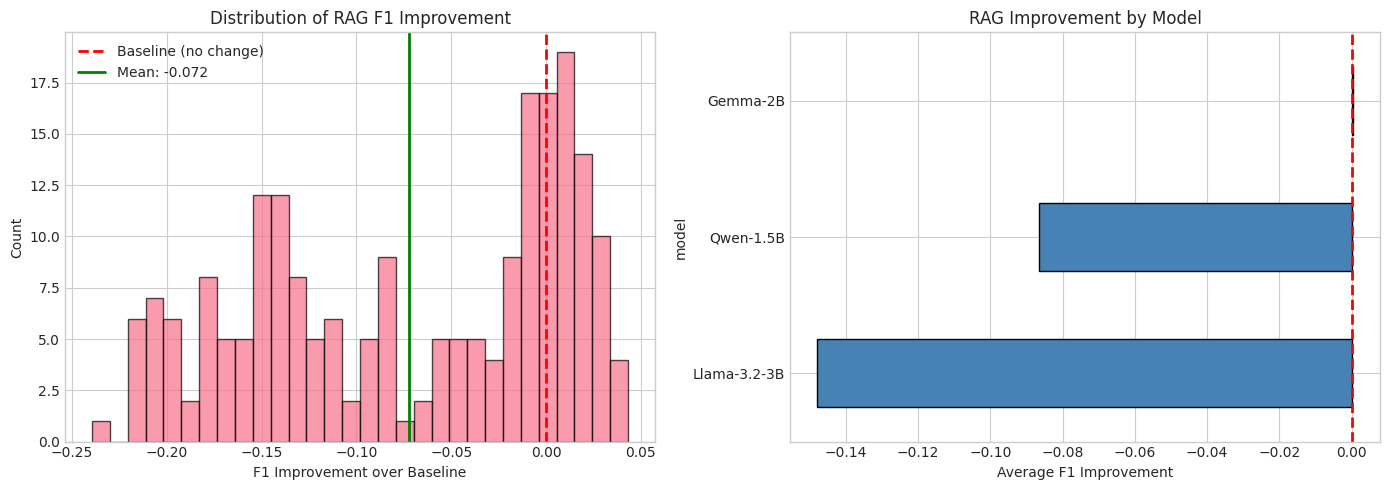

In [128]:
# Visualize RAG improvement distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of F1 improvement
ax = axes[0]
rag_with_baseline['f1_improvement'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Baseline (no change)')
ax.axvline(rag_with_baseline['f1_improvement'].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {rag_with_baseline["f1_improvement"].mean():.3f}')
ax.set_xlabel('F1 Improvement over Baseline')
ax.set_ylabel('Count')
ax.set_title('Distribution of RAG F1 Improvement')
ax.legend()

# By model
ax = axes[1]
improvement_by_model = rag_with_baseline.groupby('model')['f1_improvement'].mean().sort_values()
improvement_by_model.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Average F1 Improvement')
ax.set_title('RAG Improvement by Model')

plt.tight_layout()
plt.show()

## 3. Component Analysis: What Makes RAG Work?

Let's analyze the impact of each RAG component.

In [129]:
# Impact of Query Transform
qt_impact = rag_with_baseline.groupby('query_transform').agg({
    'f1': 'mean',
    'f1_improvement': 'mean',
    'name': 'count'
}).round(4)
qt_impact.columns = ['avg_f1', 'avg_improvement', 'count']
print("\n=== Query Transform Impact ===")
print(qt_impact.sort_values('avg_improvement', ascending=False))


=== Query Transform Impact ===
                 avg_f1  avg_improvement  count
query_transform                                
none             0.0854          -0.0672    170
hyde             0.1090          -0.0736    108
multiquery       0.1008          -0.0808    108


In [130]:
# Impact of Reranker
reranker_impact = rag_with_baseline.groupby('reranker').agg({
    'f1': 'mean',
    'f1_improvement': 'mean',
    'name': 'count'
}).round(4)
reranker_impact.columns = ['avg_f1', 'avg_improvement', 'count']
print("\n=== Reranker Impact ===")
print(reranker_impact.sort_values('avg_improvement', ascending=False))


=== Reranker Impact ===
          avg_f1  avg_improvement  count
reranker                                
none      0.0866          -0.0662    170
ms_marco  0.1110          -0.0714    108
bge       0.0970          -0.0849    108


In [131]:
# Impact of Top-K
topk_impact = rag_with_baseline.groupby('top_k').agg({
    'f1': 'mean',
    'f1_improvement': 'mean',
    'name': 'count'
}).round(4)
topk_impact.columns = ['avg_f1', 'avg_improvement', 'count']
print("\n=== Top-K Impact ===")
print(topk_impact.sort_values('avg_improvement', ascending=False))


=== Top-K Impact ===
       avg_f1  avg_improvement  count
top_k                                
3.0    0.0977          -0.0680    140
5.0    0.0990          -0.0680    138
10.0   0.0911          -0.0848    108


In [132]:
# Impact of Retriever Type
retriever_impact = rag_with_baseline.groupby('retriever_type').agg({
    'f1': 'mean',
    'f1_improvement': 'mean',
    'name': 'count'
}).round(4)
retriever_impact.columns = ['avg_f1', 'avg_improvement', 'count']
print("\n=== Retriever Type Impact ===")
print(retriever_impact.sort_values('avg_improvement', ascending=False))


=== Retriever Type Impact ===
                avg_f1  avg_improvement  count
retriever_type                                
hybrid          0.1100          -0.0618    128
dense           0.1035          -0.0639    141
hierarchical    0.0727          -0.0954    117


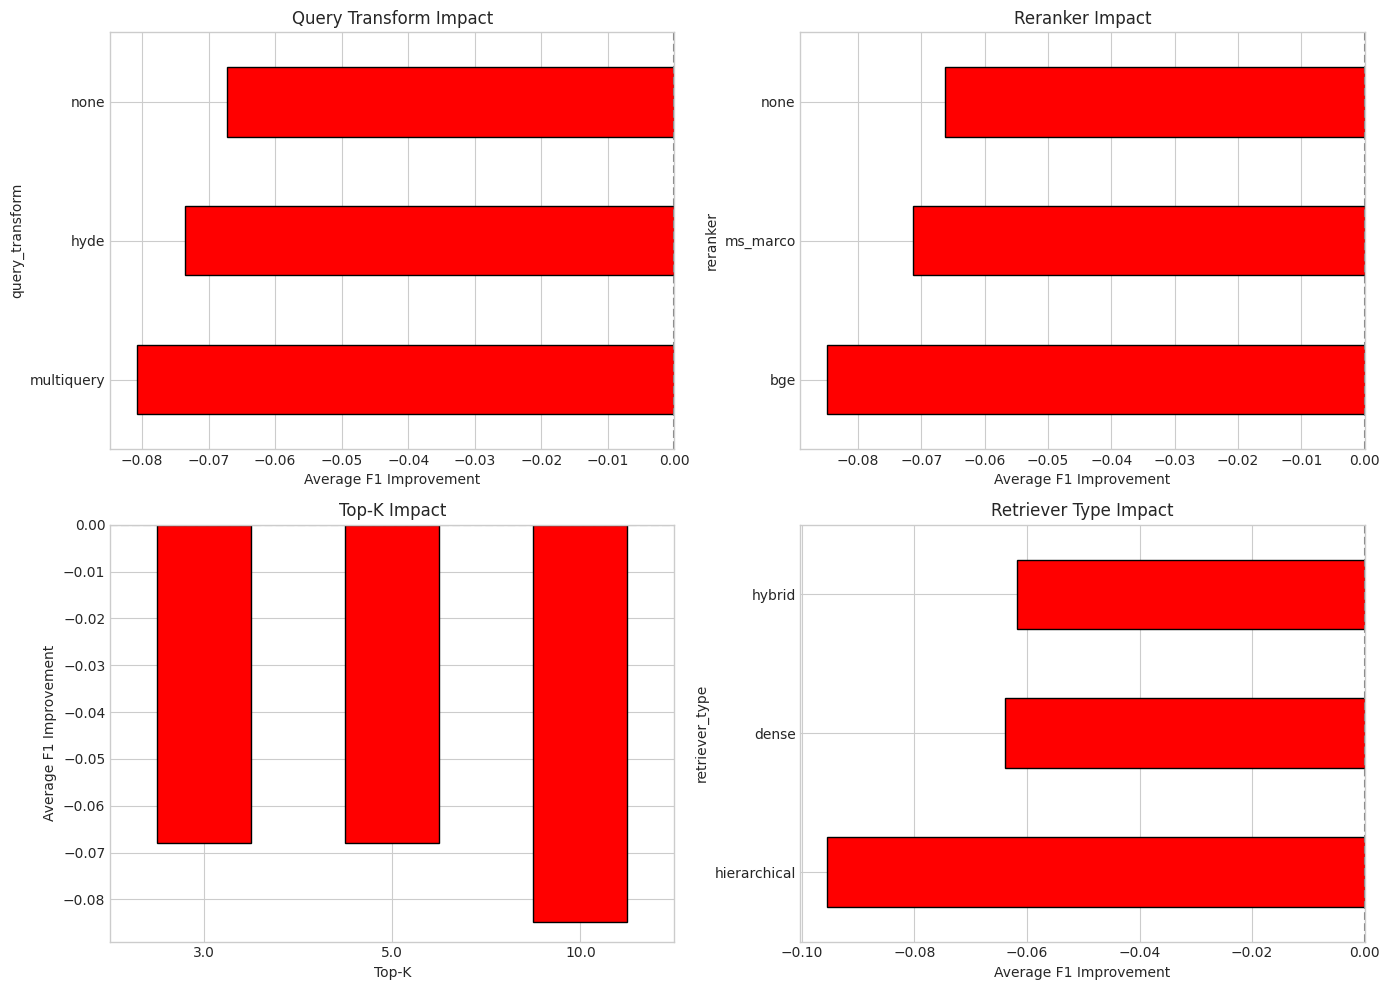

In [133]:
# Visualize component impacts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Query Transform
ax = axes[0, 0]
qt_data = rag_with_baseline.groupby('query_transform')['f1_improvement'].mean().sort_values()
colors = ['green' if v > 0 else 'red' for v in qt_data.values]
qt_data.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.axvline(0, color='gray', linestyle='--')
ax.set_xlabel('Average F1 Improvement')
ax.set_title('Query Transform Impact')

# Reranker
ax = axes[0, 1]
rr_data = rag_with_baseline.groupby('reranker')['f1_improvement'].mean().sort_values()
colors = ['green' if v > 0 else 'red' for v in rr_data.values]
rr_data.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.axvline(0, color='gray', linestyle='--')
ax.set_xlabel('Average F1 Improvement')
ax.set_title('Reranker Impact')

# Top-K
ax = axes[1, 0]
topk_data = rag_with_baseline.groupby('top_k')['f1_improvement'].mean().sort_index()
colors = ['green' if v > 0 else 'red' for v in topk_data.values]
topk_data.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Top-K')
ax.set_ylabel('Average F1 Improvement')
ax.set_title('Top-K Impact')
ax.tick_params(axis='x', rotation=0)

# Retriever Type
ax = axes[1, 1]
rt_data = rag_with_baseline.groupby('retriever_type')['f1_improvement'].mean().sort_values()
colors = ['green' if v > 0 else 'red' for v in rt_data.values]
rt_data.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.axvline(0, color='gray', linestyle='--')
ax.set_xlabel('Average F1 Improvement')
ax.set_title('Retriever Type Impact')

plt.tight_layout()
plt.show()

## 4. Best RAG Configurations

Let's find the best-performing RAG configurations.

In [134]:
# Top 20 best RAG configurations by F1 improvement
best_rag = rag_with_baseline.nlargest(20, 'f1_improvement')[[
    'model', 'retriever_type', 'top_k', 'query_transform', 'reranker',
    'prompt_style', 'f1', 'baseline_f1', 'f1_improvement'
]]

print("\n=== Top 20 Best RAG Configurations (by F1 improvement) ===")
best_rag


=== Top 20 Best RAG Configurations (by F1 improvement) ===


,model,retriever_type,top_k,query_transform,reranker,prompt_style,f1,baseline_f1,f1_improvement
265,Gemma-2B,hybrid,5.0,hyde,ms_marco,concise,0.100745,0.057504,0.043241
145,Gemma-2B,dense,5.0,hyde,none,concise,0.099287,0.057504,0.041783
4,Gemma-2B,hierarchical,5.0,none,none,concise,0.097778,0.057504,0.040273
108,Gemma-2B,hybrid,5.0,hyde,bge,concise,0.092074,0.057504,0.034570
246,Gemma-2B,dense,5.0,multiquery,ms_marco,concise,0.089343,0.057504,0.031839
234,Gemma-2B,hybrid,10.0,multiquery,none,concise,0.087474,0.057504,0.029970
339,Gemma-2B,hierarchical,3.0,multiquery,none,concise,0.086588,0.057504,0.029084
49,Gemma-2B,dense,3.0,hyde,ms_marco,concise,0.085980,0.057504,0.028476
239,Gemma-2B,dense,5.0,none,ms_marco,concise,0.084083,0.057504,0.026579
86,Gemma-2B,dense,3.0,multiquery,none,concise,0.083395,0.057504,0.025891


In [135]:
# Best configuration per model
best_per_model = rag_with_baseline.loc[
    rag_with_baseline.groupby('model')['f1_improvement'].idxmax()
][[
    'model', 'retriever_type', 'top_k', 'query_transform', 'reranker',
    'prompt_style', 'f1', 'baseline_f1', 'f1_improvement'
]]

print("\n=== Best RAG Configuration per Model ===")
best_per_model


=== Best RAG Configuration per Model ===


,model,retriever_type,top_k,query_transform,reranker,prompt_style,f1,baseline_f1,f1_improvement
265,Gemma-2B,hybrid,5.0,hyde,ms_marco,concise,0.100745,0.057504,0.043241
92,Llama-3.2-3B,dense,5.0,none,none,concise,0.129452,0.164044,-0.034592
287,Qwen-1.5B,hybrid,5.0,none,none,concise,0.041386,0.107689,-0.066303


In [136]:
# Worst RAG configurations (where RAG hurts most)
worst_rag = rag_with_baseline.nsmallest(20, 'f1_improvement')[[
    'model', 'retriever_type', 'top_k', 'query_transform', 'reranker',
    'prompt_style', 'f1', 'baseline_f1', 'f1_improvement'
]]

print("\n=== Top 20 Worst RAG Configurations (RAG hurts most) ===")
worst_rag


=== Top 20 Worst RAG Configurations (RAG hurts most) ===


,model,retriever_type,top_k,query_transform,reranker,prompt_style,f1,baseline_f1,f1_improvement
167,Llama-3.2-3B,hierarchical,10.0,multiquery,bge,concise,0.028578,0.267985,-0.239407
286,Llama-3.2-3B,hierarchical,3.0,multiquery,bge,concise,0.047828,0.267985,-0.220157
277,Llama-3.2-3B,hierarchical,5.0,none,bge,concise,0.047907,0.267985,-0.220077
385,Llama-3.2-3B,hierarchical,10.0,none,none,concise,0.051364,0.267985,-0.216621
254,Llama-3.2-3B,hierarchical,10.0,multiquery,none,concise,0.052189,0.267985,-0.215796
249,Llama-3.2-3B,hierarchical,3.0,hyde,bge,concise,0.054357,0.267985,-0.213628
7,Llama-3.2-3B,hierarchical,10.0,none,bge,concise,0.054637,0.267985,-0.213348
51,Llama-3.2-3B,hierarchical,10.0,hyde,none,concise,0.057717,0.267985,-0.210267
78,Llama-3.2-3B,hierarchical,5.0,multiquery,none,concise,0.057930,0.267985,-0.210055
205,Llama-3.2-3B,hierarchical,5.0,multiquery,bge,concise,0.058985,0.267985,-0.209000


## 5. Interaction Effects

Let's see how components interact with each other.


=== Query Transform x Reranker Interaction (F1 Improvement) ===
reranker            bge  ms_marco    none
query_transform                          
hyde            -0.0823   -0.0718 -0.0666
multiquery      -0.0899   -0.0707 -0.0816
none            -0.0824   -0.0716 -0.0620


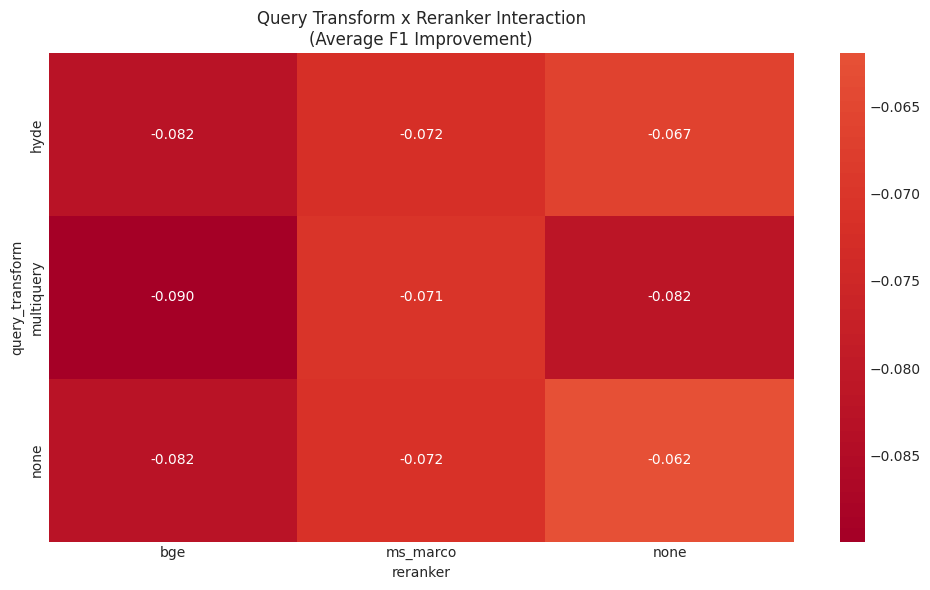

In [137]:
# Query Transform x Reranker interaction
qt_rr_interaction = rag_with_baseline.pivot_table(
    values='f1_improvement',
    index='query_transform',
    columns='reranker',
    aggfunc='mean'
)

print("\n=== Query Transform x Reranker Interaction (F1 Improvement) ===")
print(qt_rr_interaction.round(4))

plt.figure(figsize=(10, 6))
sns.heatmap(qt_rr_interaction, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
plt.title('Query Transform x Reranker Interaction\n(Average F1 Improvement)')
plt.tight_layout()
plt.show()


=== Model x Retriever Type Interaction (F1 Improvement) ===
retriever_type   dense  hierarchical  hybrid
model                                       
Gemma-2B        0.0057       -0.0135  0.0085
Llama-3.2-3B   -0.1294       -0.1961 -0.1293
Qwen-1.5B      -0.0885       -0.0833 -0.0843


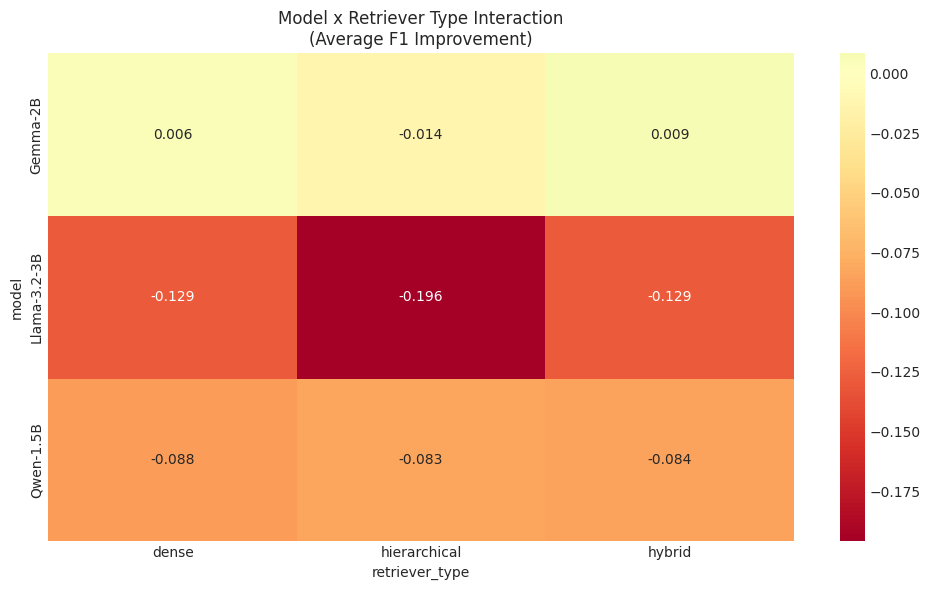

In [138]:
# Model x Retriever Type interaction
model_retriever_interaction = rag_with_baseline.pivot_table(
    values='f1_improvement',
    index='model',
    columns='retriever_type',
    aggfunc='mean'
)

print("\n=== Model x Retriever Type Interaction (F1 Improvement) ===")
print(model_retriever_interaction.round(4))

plt.figure(figsize=(10, 6))
sns.heatmap(model_retriever_interaction, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
plt.title('Model x Retriever Type Interaction\n(Average F1 Improvement)')
plt.tight_layout()
plt.show()


=== Top-K x Reranker Interaction (F1 Improvement) ===
reranker     bge  ms_marco    none
top_k                             
3.0      -0.0819   -0.0643 -0.0638
5.0      -0.0819   -0.0707 -0.0609
10.0     -0.0908   -0.0791 -0.0844


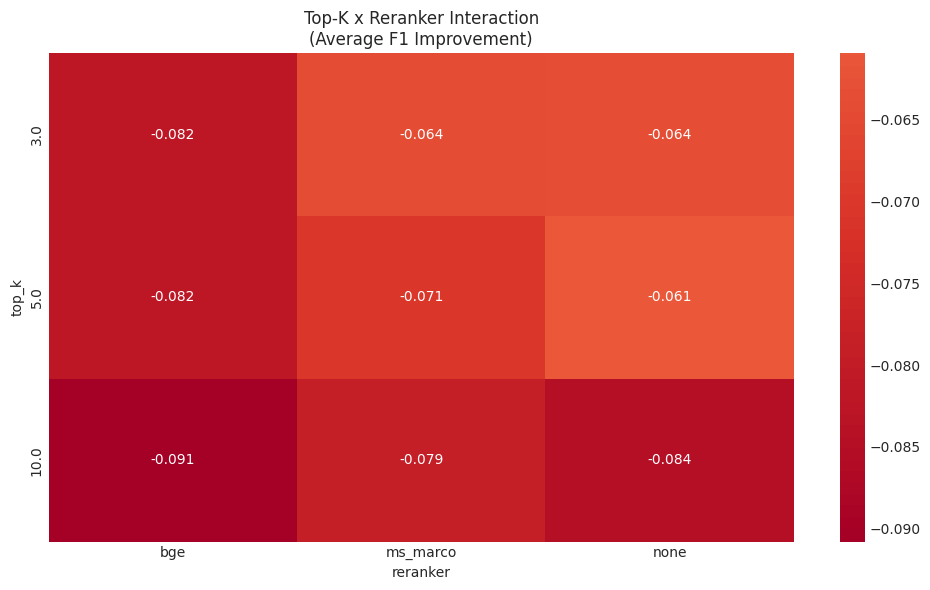

In [139]:
# Top-K x Reranker interaction
topk_rr_interaction = rag_with_baseline.pivot_table(
    values='f1_improvement',
    index='top_k',
    columns='reranker',
    aggfunc='mean'
)

print("\n=== Top-K x Reranker Interaction (F1 Improvement) ===")
print(topk_rr_interaction.round(4))

plt.figure(figsize=(10, 6))
sns.heatmap(topk_rr_interaction, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
plt.title('Top-K x Reranker Interaction\n(Average F1 Improvement)')
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Let's use a simple model to understand which features matter most for RAG performance.

In [140]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Prepare features for modeling
feature_cols = ['model', 'retriever_type', 'retriever_name', 'top_k', 
                'query_transform', 'reranker', 'prompt_style', 'dataset']

# Filter to rows with all features
model_df = rag_with_baseline.dropna(subset=feature_cols + ['f1_improvement']).copy()

# Encode categorical variables
encoders = {}
X_encoded = pd.DataFrame()

for col in feature_cols:
    if model_df[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(model_df[col].astype(str))
        encoders[col] = le
    else:
        X_encoded[col] = model_df[col]

y = model_df['f1_improvement']

print(f"Training on {len(X_encoded)} samples with {len(feature_cols)} features")

Training on 211 samples with 8 features


## 10. Per-Question Answer Comparison: RAG vs Direct LLM

This section provides a detailed comparison of individual answers with and without RAG.
We examine:
- **Improved Questions**: Where RAG helped the model answer correctly
- **Degraded Questions**: Where RAG context actually hurt performance  
- **Unaffected Questions**: Where performance was similar with/without RAG

For each case, we show the question, expected answer, both model responses, and the retrieved context.

In [141]:
def load_predictions(exp_name: str, study_path: Path) -> Dict[str, Any]:
    """Load predictions for a single experiment."""
    pred_file = study_path / exp_name / "predictions.json"
    if not pred_file.exists():
        return None
    with open(pred_file) as f:
        return json.load(f)

def compare_rag_vs_direct(
    rag_exp_name: str,
    direct_exp_name: str,
    study_path: Path,
    metric: str = 'f1'
) -> pd.DataFrame:
    """Compare predictions between RAG and direct experiments."""
    rag_preds = load_predictions(rag_exp_name, study_path)
    direct_preds = load_predictions(direct_exp_name, study_path)
    
    if not rag_preds or not direct_preds:
        return None
    
    # Create lookup for direct predictions by idx
    direct_by_idx = {p['idx']: p for p in direct_preds['predictions']}
    
    comparisons = []
    for rag_p in rag_preds['predictions']:
        idx = rag_p['idx']
        if idx not in direct_by_idx:
            continue
        
        direct_p = direct_by_idx[idx]
        
        rag_score = rag_p['metrics'].get(metric, 0)
        direct_score = direct_p['metrics'].get(metric, 0)
        delta = rag_score - direct_score
        
        comparisons.append({
            'idx': idx,
            'question': rag_p['question'],
            'expected': rag_p['expected'],
            'direct_answer': direct_p['prediction'],
            'rag_answer': rag_p['prediction'],
            'direct_prompt': direct_p.get('prompt', ''),
            'rag_prompt': rag_p.get('prompt', ''),
            'retrieved_docs': rag_p.get('retrieved_docs', []),
            f'direct_{metric}': direct_score,
            f'rag_{metric}': rag_score,
            f'{metric}_delta': delta,
            'direct_metrics': direct_p['metrics'],
            'rag_metrics': rag_p['metrics'],
        })
    
    return pd.DataFrame(comparisons)

print("Comparison functions loaded.")

Comparison functions loaded.


In [142]:
from IPython.display import display, HTML, Markdown

def display_comparison(row: pd.Series, show_full_prompt: bool = False):
    """Display a formatted comparison for a single question."""
    
    # Determine category and color
    delta = row['f1_delta']
    if delta > 0.1:
        category = "IMPROVED"
        color = "#2e7d32"  # green
    elif delta < -0.1:
        category = "DEGRADED"
        color = "#c62828"  # red
    else:
        category = "UNAFFECTED"
        color = "#1565c0"  # blue
    
    # Format expected answers
    expected_str = ", ".join(row['expected']) if isinstance(row['expected'], list) else str(row['expected'])
    
    # Format retrieved docs
    docs_html = ""
    if row['retrieved_docs']:
        docs_html = "<div style='background-color:#f5f5f5; padding:10px; margin:5px 0; border-radius:5px;'>"
        docs_html += "<strong>Retrieved Context:</strong><br>"
        for doc in row['retrieved_docs']:
            score = doc.get('score', 0)
            content = doc.get('content', '')[:500]  # Truncate long content
            if len(doc.get('content', '')) > 500:
                content += "..."
            docs_html += f"<div style='margin:5px 0; padding:5px; border-left:3px solid #1976d2;'>"
            docs_html += f"<small>[Rank {doc.get('rank', '?')} | Score: {score:.4f}]</small><br>"
            docs_html += f"<code style='white-space:pre-wrap;'>{content}</code></div>"
        docs_html += "</div>"
    
    html = f"""
    <div style='border:2px solid {color}; padding:15px; margin:10px 0; border-radius:10px;'>
        <div style='display:flex; justify-content:space-between; align-items:center;'>
            <span style='font-size:1.2em; font-weight:bold;'>Question #{row['idx']}</span>
            <span style='background-color:{color}; color:white; padding:5px 10px; border-radius:5px;'>{category} (Δ F1: {delta:+.4f})</span>
        </div>
        
        <div style='margin:15px 0;'>
            <strong>Question:</strong> {row['question']}
        </div>
        
        <div style='margin:15px 0; padding:10px; background-color:#e8f5e9; border-radius:5px;'>
            <strong>Expected Answer:</strong> {expected_str}
        </div>
        
        <div style='display:grid; grid-template-columns:1fr 1fr; gap:10px; margin:15px 0;'>
            <div style='padding:10px; background-color:#fff3e0; border-radius:5px;'>
                <strong>Direct LLM Answer</strong>
                <div style='margin-top:5px;'>
                    <span style='font-size:0.9em; color:#666;'>F1: {row['direct_f1']:.4f}</span>
                </div>
                <div style='margin-top:10px; font-style:italic;'>{row['direct_answer']}</div>
            </div>
            <div style='padding:10px; background-color:#e3f2fd; border-radius:5px;'>
                <strong>RAG Answer</strong>
                <div style='margin-top:5px;'>
                    <span style='font-size:0.9em; color:#666;'>F1: {row['rag_f1']:.4f}</span>
                </div>
                <div style='margin-top:10px; font-style:italic;'>{row['rag_answer']}</div>
            </div>
        </div>
        
        {docs_html}
    </div>
    """
    display(HTML(html))

def display_comparison_summary(comp_df: pd.DataFrame, metric: str = 'f1'):
    """Display summary statistics for the comparison."""
    improved = (comp_df[f'{metric}_delta'] > 0.1).sum()
    degraded = (comp_df[f'{metric}_delta'] < -0.1).sum()
    unaffected = len(comp_df) - improved - degraded
    
    avg_delta = comp_df[f'{metric}_delta'].mean()
    
    html = f"""
    <div style='background-color:#263238; color:white; padding:20px; border-radius:10px; margin:10px 0;'>
        <h3 style='margin:0 0 15px 0;'>Comparison Summary</h3>
        <div style='display:grid; grid-template-columns:repeat(4, 1fr); gap:15px;'>
            <div style='text-align:center; padding:15px; background-color:#2e7d32; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{improved}</div>
                <div>Improved</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#c62828; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{degraded}</div>
                <div>Degraded</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#1565c0; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{unaffected}</div>
                <div>Unaffected</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#6a1b9a; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{avg_delta:+.4f}</div>
                <div>Avg Δ {metric.upper()}</div>
            </div>
        </div>
    </div>
    """
    display(HTML(html))

print("Display functions loaded.")

Display functions loaded.


In [143]:
# Find available direct baselines to compare against
direct_experiments = [d.name for d in STUDY_PATH.iterdir() if d.is_dir() and d.name.startswith('direct_')]
print("Available direct baselines:")
for exp in direct_experiments:
    print(f"  - {exp}")

# Map to extract model and dataset from experiment names
def get_model_dataset_from_name(name: str) -> tuple:
    """Extract model and dataset from experiment name."""
    if 'metallama_Llama3.23BInstruct' in name:
        model = 'Llama-3.2-3B'
    elif 'google_gemma2bit' in name:
        model = 'Gemma-2B'
    elif 'Qwen_Qwen2.51.5BInstruct' in name:
        model = 'Qwen-1.5B'
    else:
        model = None
    
    if '_nq_' in name:
        dataset = 'nq'
    elif '_hotpotqa_' in name:
        dataset = 'hotpotqa'
    else:
        dataset = None
    
    return model, dataset

# Create lookup for direct baselines
direct_baselines = {}
for exp in direct_experiments:
    model, dataset = get_model_dataset_from_name(exp)
    if model and dataset:
        direct_baselines[(model, dataset)] = exp
        
print(f"\nDirect baseline lookup: {direct_baselines}")

Available direct baselines:
  - direct_hf_google_gemma2bit_concise_hotpotqa_none
  - direct_hf_metallama_Llama3.23BInstruct_concise_nq_none
  - direct_hf_google_gemma2bit_concise_nq_none
  - direct_hf_metallama_Llama3.23BInstruct_concise_hotpotqa_none
  - direct_hf_Qwen_Qwen2.51.5BInstruct_concise_hotpotqa_none
  - direct_hf_Qwen_Qwen2.51.5BInstruct_concise_nq_none

Direct baseline lookup: {('Gemma-2B', 'hotpotqa'): 'direct_hf_google_gemma2bit_concise_hotpotqa_none', ('Llama-3.2-3B', 'nq'): 'direct_hf_metallama_Llama3.23BInstruct_concise_nq_none', ('Gemma-2B', 'nq'): 'direct_hf_google_gemma2bit_concise_nq_none', ('Llama-3.2-3B', 'hotpotqa'): 'direct_hf_metallama_Llama3.23BInstruct_concise_hotpotqa_none', ('Qwen-1.5B', 'hotpotqa'): 'direct_hf_Qwen_Qwen2.51.5BInstruct_concise_hotpotqa_none', ('Qwen-1.5B', 'nq'): 'direct_hf_Qwen_Qwen2.51.5BInstruct_concise_nq_none'}


### 10.1 Select Experiments to Compare

Choose a RAG configuration to compare against the direct LLM baseline.

In [144]:
# Select a RAG experiment to compare
# Using the best and worst configurations we found earlier

# Find experiments with the most improvement and degradation
top_rag = rag_with_baseline.nlargest(10, 'f1_improvement')[['name', 'model', 'dataset', 'f1_improvement', 'f1', 'baseline_f1']]
bottom_rag = rag_with_baseline.nsmallest(10, 'f1_improvement')[['name', 'model', 'dataset', 'f1_improvement', 'f1', 'baseline_f1']]

print("=== TOP 10 RAG CONFIGURATIONS (Most Improvement) ===")
display(top_rag)

print("\n=== BOTTOM 10 RAG CONFIGURATIONS (Most Degradation) ===")
display(bottom_rag)

=== TOP 10 RAG CONFIGURATIONS (Most Improvement) ===


,name,model,dataset,f1_improvement,f1,baseline_f1
265,rag_hf_google_gemma2bit_hybrid_bge_k5_hyde_rer...,Gemma-2B,nq,0.043241,0.100745,0.057504
145,rag_hf_google_gemma2bit_dense_bge_large_k5_hyd...,Gemma-2B,nq,0.041783,0.099287,0.057504
4,rag_hf_google_gemma2bit_hierarchical_bge_2048_...,Gemma-2B,nq,0.040273,0.097778,0.057504
108,rag_hf_google_gemma2bit_hybrid_bge_k5_hyde_rer...,Gemma-2B,nq,0.034570,0.092074,0.057504
246,rag_hf_google_gemma2bit_dense_bge_large_k5_mul...,Gemma-2B,nq,0.031839,0.089343,0.057504
234,rag_hf_google_gemma2bit_hybrid_bge_k10_multiqu...,Gemma-2B,nq,0.029970,0.087474,0.057504
339,rag_hf_google_gemma2bit_hierarchical_bge_3072_...,Gemma-2B,nq,0.029084,0.086588,0.057504
49,rag_hf_google_gemma2bit_dense_bge_large_k3_hyd...,Gemma-2B,nq,0.028476,0.085980,0.057504
239,rag_hf_google_gemma2bit_dense_bge_large_k5_rer...,Gemma-2B,nq,0.026579,0.084083,0.057504
86,rag_hf_google_gemma2bit_dense_bge_large_k3_mul...,Gemma-2B,nq,0.025891,0.083395,0.057504



=== BOTTOM 10 RAG CONFIGURATIONS (Most Degradation) ===


,name,model,dataset,f1_improvement,f1,baseline_f1
167,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.239407,0.028578,0.267985
286,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.220157,0.047828,0.267985
277,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.220077,0.047907,0.267985
385,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.216621,0.051364,0.267985
254,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.215796,0.052189,0.267985
249,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.213628,0.054357,0.267985
7,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.213348,0.054637,0.267985
51,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.210267,0.057717,0.267985
78,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.210055,0.057930,0.267985
205,rag_hf_metallama_Llama3.23BInstruct_hierarchic...,Llama-3.2-3B,nq,-0.209000,0.058985,0.267985


In [145]:
# ==============================================================================
# SELECT YOUR EXPERIMENTS HERE
# ==============================================================================
# Pick a RAG experiment from the top/bottom lists above, or any RAG experiment

# Example: Compare best Llama-3.2-3B RAG config vs direct
SELECTED_RAG_EXP = top_rag.iloc[0]['name']  # Best improvement
SELECTED_MODEL = top_rag.iloc[0]['model']
SELECTED_DATASET = top_rag.iloc[0]['dataset']

# Get corresponding direct baseline
DIRECT_EXP = direct_baselines.get((SELECTED_MODEL, SELECTED_DATASET))

print(f"Comparing:")
print(f"  RAG: {SELECTED_RAG_EXP}")
print(f"  Direct: {DIRECT_EXP}")
print(f"  Model: {SELECTED_MODEL}, Dataset: {SELECTED_DATASET}")

Comparing:
  RAG: rag_hf_google_gemma2bit_hybrid_bge_k5_hyde_rerank_ms_marco_concise_nq_none
  Direct: direct_hf_google_gemma2bit_concise_nq_none
  Model: Gemma-2B, Dataset: nq


In [146]:
# Load and compare predictions
if DIRECT_EXP:
    comparison_df = compare_rag_vs_direct(SELECTED_RAG_EXP, DIRECT_EXP, STUDY_PATH, metric='f1')
    
    if comparison_df is not None and len(comparison_df) > 0:
        print(f"Loaded {len(comparison_df)} question comparisons")
        display_comparison_summary(comparison_df, metric='f1')
    else:
        print("Could not load predictions for comparison")
else:
    print(f"No direct baseline found for {SELECTED_MODEL} on {SELECTED_DATASET}")

Loaded 100 question comparisons


### 10.2 Questions Where RAG IMPROVED Performance

These are questions where the retrieved context helped the model provide a better answer.

In [147]:
# Show questions where RAG improved performance
NUM_EXAMPLES = 5  # Number of examples to show per category

if comparison_df is not None:
    improved = comparison_df[comparison_df['f1_delta'] > 0.1].sort_values('f1_delta', ascending=False)
    print(f"Found {len(improved)} questions where RAG improved performance (Δ F1 > 0.1)")
    print(f"Showing top {min(NUM_EXAMPLES, len(improved))} examples:\n")
    
    for _, row in improved.head(NUM_EXAMPLES).iterrows():
        display_comparison(row)

Found 16 questions where RAG improved performance (Δ F1 > 0.1)
Showing top 5 examples:



### 10.3 Questions Where RAG DEGRADED Performance

These are questions where the retrieved context actually hurt the model's performance.
This can happen when:
- Retrieved documents are irrelevant or misleading
- The model gets confused by conflicting information
- The model already knew the answer but context introduced noise

In [148]:
# Show questions where RAG degraded performance
if comparison_df is not None:
    degraded = comparison_df[comparison_df['f1_delta'] < -0.1].sort_values('f1_delta', ascending=True)
    print(f"Found {len(degraded)} questions where RAG degraded performance (Δ F1 < -0.1)")
    print(f"Showing top {min(NUM_EXAMPLES, len(degraded))} examples:\n")
    
    for _, row in degraded.head(NUM_EXAMPLES).iterrows():
        display_comparison(row)

Found 9 questions where RAG degraded performance (Δ F1 < -0.1)
Showing top 5 examples:



### 10.4 Questions Where RAG Had MINIMAL Impact

These are questions where performance was similar with or without RAG.
This can happen when:
- The model already knew the answer confidently
- Both failed to answer correctly  
- The retrieved context was not particularly helpful or harmful

In [149]:
# Show questions where RAG had minimal impact (random sample)
if comparison_df is not None:
    unaffected = comparison_df[
        (comparison_df['f1_delta'] >= -0.1) & 
        (comparison_df['f1_delta'] <= 0.1)
    ]
    print(f"Found {len(unaffected)} questions where RAG had minimal impact (-0.1 ≤ Δ F1 ≤ 0.1)")
    print(f"Showing {min(NUM_EXAMPLES, len(unaffected))} random examples:\n")
    
    # Sample randomly to show variety
    sample = unaffected.sample(min(NUM_EXAMPLES, len(unaffected)), random_state=42)
    for _, row in sample.iterrows():
        display_comparison(row)

Found 75 questions where RAG had minimal impact (-0.1 ≤ Δ F1 ≤ 0.1)
Showing 5 random examples:



### 10.5 Compare a Degraded RAG Configuration

Let's also look at questions from a RAG configuration that performed worse than the baseline to understand failure cases.

In [150]:
# Select a degraded RAG experiment
DEGRADED_RAG_EXP = bottom_rag.iloc[0]['name']
DEGRADED_MODEL = bottom_rag.iloc[0]['model']
DEGRADED_DATASET = bottom_rag.iloc[0]['dataset']

DEGRADED_DIRECT_EXP = direct_baselines.get((DEGRADED_MODEL, DEGRADED_DATASET))

print(f"Comparing DEGRADED configuration:")
print(f"  RAG: {DEGRADED_RAG_EXP}")
print(f"  Direct: {DEGRADED_DIRECT_EXP}")
print(f"  Model: {DEGRADED_MODEL}, Dataset: {DEGRADED_DATASET}\n")

if DEGRADED_DIRECT_EXP:
    degraded_comparison_df = compare_rag_vs_direct(DEGRADED_RAG_EXP, DEGRADED_DIRECT_EXP, STUDY_PATH, metric='f1')
    
    if degraded_comparison_df is not None and len(degraded_comparison_df) > 0:
        display_comparison_summary(degraded_comparison_df, metric='f1')
    else:
        print("Could not load predictions for comparison")

Comparing DEGRADED configuration:
  RAG: rag_hf_metallama_Llama3.23BInstruct_hierarchical_bge_3072_768_k10_multiquery_rerank_bge_concise_nq_none
  Direct: direct_hf_metallama_Llama3.23BInstruct_concise_nq_none
  Model: Llama-3.2-3B, Dataset: nq



In [151]:
# Show examples where the degraded config hurt performance
if degraded_comparison_df is not None:
    worst_cases = degraded_comparison_df[degraded_comparison_df['f1_delta'] < -0.1].sort_values('f1_delta', ascending=True)
    print(f"Showing {min(3, len(worst_cases))} worst degradation cases from this config:\n")
    
    for _, row in worst_cases.head(3).iterrows():
        display_comparison(row)

Showing 3 worst degradation cases from this config:



### 10.6 Retriever Effectiveness Analysis

Let's analyze how effective the retriever was at finding relevant context.
We'll look at the relationship between retrieval scores and answer quality.

In [152]:
def analyze_retrieval_quality(comp_df: pd.DataFrame) -> pd.DataFrame:
    """Analyze retrieval quality metrics."""
    analysis = []
    
    for _, row in comp_df.iterrows():
        docs = row['retrieved_docs']
        if not docs:
            continue
            
        # Compute retrieval statistics
        scores = [d.get('score', 0) for d in docs]
        avg_score = np.mean(scores)
        max_score = max(scores)
        min_score = min(scores)
        
        # Check if expected answer appears in retrieved docs
        expected = row['expected']
        if isinstance(expected, str):
            expected = [expected]
        
        all_content = " ".join([d.get('content', '').lower() for d in docs])
        answer_in_context = any(exp.lower() in all_content for exp in expected)
        
        analysis.append({
            'idx': row['idx'],
            'question': row['question'],
            'avg_retrieval_score': avg_score,
            'max_retrieval_score': max_score,
            'min_retrieval_score': min_score,
            'num_docs': len(docs),
            'answer_in_context': answer_in_context,
            'f1_delta': row['f1_delta'],
            'rag_f1': row['rag_f1'],
            'direct_f1': row['direct_f1'],
            'category': 'improved' if row['f1_delta'] > 0.1 else ('degraded' if row['f1_delta'] < -0.1 else 'unaffected')
        })
    
    return pd.DataFrame(analysis)

if comparison_df is not None:
    retrieval_analysis = analyze_retrieval_quality(comparison_df)
    print(f"Analyzed {len(retrieval_analysis)} questions\n")
    
    # Summary by category
    summary = retrieval_analysis.groupby('category').agg({
        'avg_retrieval_score': 'mean',
        'max_retrieval_score': 'mean',
        'answer_in_context': 'mean',
        'f1_delta': 'mean',
        'idx': 'count'
    }).rename(columns={'idx': 'count'})
    
    print("=== Retrieval Quality by Category ===")
    display(summary.round(4))

Analyzed 100 questions

=== Retrieval Quality by Category ===


,avg_retrieval_score,max_retrieval_score,answer_in_context,f1_delta,count
category,,,,,
degraded,1.3714,4.7078,0.5556,-0.2896,9
improved,3.1399,4.8978,0.6875,0.4304,16
unaffected,1.4246,3.7598,0.2133,0.0006,75


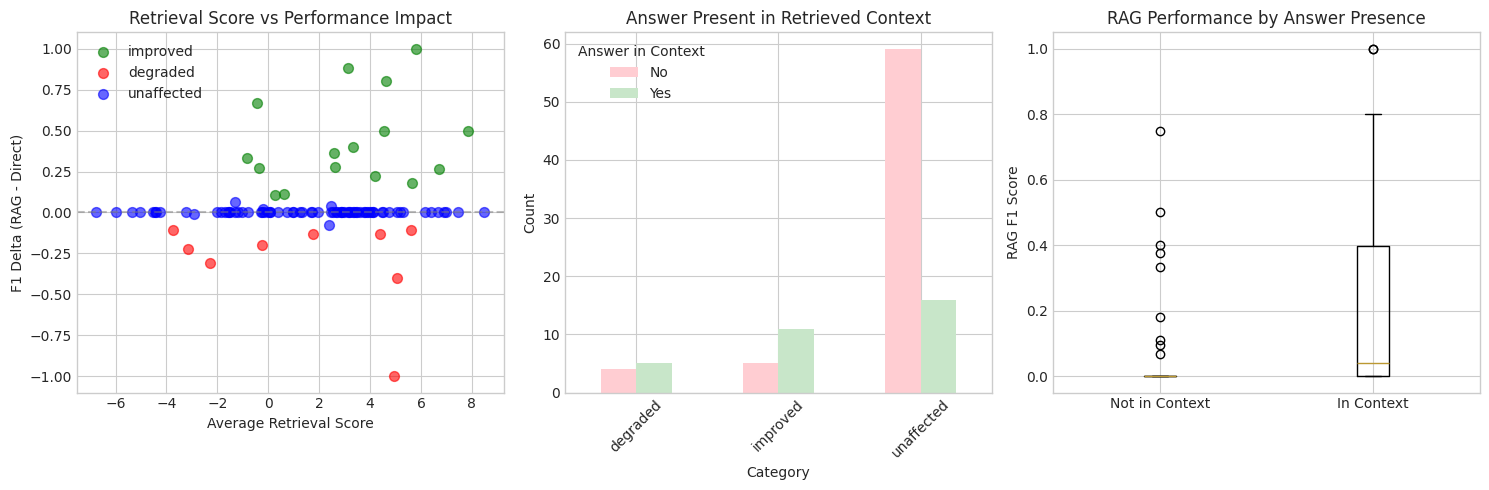


=== Key Insights ===
Questions where answer was in retrieved context: 32 (32.0%)

When answer IS in context:
  - Avg RAG F1: 0.2269
  - Avg F1 Delta: +0.1044

When answer is NOT in context:
  - Avg RAG F1: 0.0414
  - Avg F1 Delta: +0.0145


In [153]:
# Visualize retrieval scores vs performance impact
if retrieval_analysis is not None and len(retrieval_analysis) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Retrieval score vs F1 delta
    ax1 = axes[0]
    colors = {'improved': 'green', 'degraded': 'red', 'unaffected': 'blue'}
    for cat in ['improved', 'degraded', 'unaffected']:
        cat_data = retrieval_analysis[retrieval_analysis['category'] == cat]
        ax1.scatter(cat_data['avg_retrieval_score'], cat_data['f1_delta'], 
                   c=colors[cat], label=cat, alpha=0.6, s=50)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Average Retrieval Score')
    ax1.set_ylabel('F1 Delta (RAG - Direct)')
    ax1.set_title('Retrieval Score vs Performance Impact')
    ax1.legend()
    
    # 2. Answer in context distribution
    ax2 = axes[1]
    answer_dist = retrieval_analysis.groupby(['category', 'answer_in_context']).size().unstack(fill_value=0)
    answer_dist.plot(kind='bar', ax=ax2, color=['#ffcdd2', '#c8e6c9'])
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Count')
    ax2.set_title('Answer Present in Retrieved Context')
    ax2.legend(['No', 'Yes'], title='Answer in Context')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. RAG F1 when answer is/isn't in context
    ax3 = axes[2]
    in_context = retrieval_analysis[retrieval_analysis['answer_in_context'] == True]['rag_f1']
    not_in_context = retrieval_analysis[retrieval_analysis['answer_in_context'] == False]['rag_f1']
    
    ax3.boxplot([not_in_context, in_context], labels=['Not in Context', 'In Context'])
    ax3.set_ylabel('RAG F1 Score')
    ax3.set_title('RAG Performance by Answer Presence')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\n=== Key Insights ===")
    print(f"Questions where answer was in retrieved context: {retrieval_analysis['answer_in_context'].sum()} "
          f"({retrieval_analysis['answer_in_context'].mean()*100:.1f}%)")
    
    # Performance when answer is in context
    in_ctx = retrieval_analysis[retrieval_analysis['answer_in_context']]
    not_in_ctx = retrieval_analysis[~retrieval_analysis['answer_in_context']]
    
    if len(in_ctx) > 0 and len(not_in_ctx) > 0:
        print(f"\nWhen answer IS in context:")
        print(f"  - Avg RAG F1: {in_ctx['rag_f1'].mean():.4f}")
        print(f"  - Avg F1 Delta: {in_ctx['f1_delta'].mean():+.4f}")
        print(f"\nWhen answer is NOT in context:")
        print(f"  - Avg RAG F1: {not_in_ctx['rag_f1'].mean():.4f}")
        print(f"  - Avg F1 Delta: {not_in_ctx['f1_delta'].mean():+.4f}")

### 10.7 Interactive Comparison Tool

Use the function below to compare any RAG experiment against its direct baseline.

In [154]:
def compare_experiment(
    rag_exp_name: str = None,
    model: str = 'Llama-3.2-3B',
    dataset: str = 'nq',
    show_improved: int = 3,
    show_degraded: int = 3,
    show_unaffected: int = 2
):
    """
    Interactive function to compare any RAG experiment against its direct baseline.
    
    Args:
        rag_exp_name: Full name of RAG experiment. If None, uses first matching experiment.
        model: Model name to filter experiments ('Llama-3.2-3B', 'Gemma-2B', 'Qwen-1.5B')
        dataset: Dataset name ('nq' or 'hotpotqa')
        show_improved: Number of improved examples to show
        show_degraded: Number of degraded examples to show
        show_unaffected: Number of unaffected examples to show
    """
    # Find direct baseline
    direct_exp = direct_baselines.get((model, dataset))
    if not direct_exp:
        print(f"No direct baseline found for {model} on {dataset}")
        return
    
    # If no RAG experiment specified, find the first matching one
    if rag_exp_name is None:
        matching = rag_with_baseline[
            (rag_with_baseline['model'] == model) & 
            (rag_with_baseline['dataset'] == dataset)
        ]
        if len(matching) == 0:
            print(f"No RAG experiments found for {model} on {dataset}")
            return
        rag_exp_name = matching.iloc[0]['name']
    
    print(f"=" * 80)
    print(f"COMPARING: {rag_exp_name}")
    print(f"BASELINE:  {direct_exp}")
    print(f"=" * 80)
    
    # Load comparison
    comp = compare_rag_vs_direct(rag_exp_name, direct_exp, STUDY_PATH, metric='f1')
    if comp is None or len(comp) == 0:
        print("Could not load predictions")
        return
    
    display_comparison_summary(comp, metric='f1')
    
    # Show examples from each category
    improved = comp[comp['f1_delta'] > 0.1].sort_values('f1_delta', ascending=False)
    degraded = comp[comp['f1_delta'] < -0.1].sort_values('f1_delta', ascending=True)
    unaffected = comp[(comp['f1_delta'] >= -0.1) & (comp['f1_delta'] <= 0.1)]
    
    if show_improved > 0 and len(improved) > 0:
        print(f"\n{'='*40}")
        print(f"IMPROVED EXAMPLES ({len(improved)} total)")
        print(f"{'='*40}")
        for _, row in improved.head(show_improved).iterrows():
            display_comparison(row)
    
    if show_degraded > 0 and len(degraded) > 0:
        print(f"\n{'='*40}")
        print(f"DEGRADED EXAMPLES ({len(degraded)} total)")
        print(f"{'='*40}")
        for _, row in degraded.head(show_degraded).iterrows():
            display_comparison(row)
    
    if show_unaffected > 0 and len(unaffected) > 0:
        print(f"\n{'='*40}")
        print(f"UNAFFECTED EXAMPLES ({len(unaffected)} total)")
        print(f"{'='*40}")
        sample = unaffected.sample(min(show_unaffected, len(unaffected)), random_state=42)
        for _, row in sample.iterrows():
            display_comparison(row)
    
    return comp

# Example usage:
# compare_experiment(model='Llama-3.2-3B', dataset='nq', show_improved=2, show_degraded=2)

In [155]:
# Try it out - compare a specific experiment
# Uncomment and modify the line below to explore different configurations:

# compare_experiment(
#     rag_exp_name='rag_hf_metallama_Llama3.23BInstruct_dense_bge_large_k3_concise_nq_none',
#     model='Llama-3.2-3B',
#     dataset='nq',
#     show_improved=3,
#     show_degraded=3,
#     show_unaffected=2
# )

# Or compare any model/dataset combination:
# compare_experiment(model='Gemma-2B', dataset='hotpotqa')
# compare_experiment(model='Qwen-1.5B', dataset='nq')

print("Use compare_experiment() to explore different RAG configurations!")
print("\nAvailable models:", list(set([m for m, d in direct_baselines.keys()])))
print("Available datasets:", list(set([d for m, d in direct_baselines.keys()])))

Use compare_experiment() to explore different RAG configurations!

Available models: ['Qwen-1.5B', 'Gemma-2B', 'Llama-3.2-3B']
Available datasets: ['hotpotqa', 'nq']


### 10.8 Summary of Per-Question Comparison Insights

Based on the per-question analysis, we can observe:

1. **When RAG Helps**: Questions requiring specific factual knowledge that the model lacks (e.g., dates, names, statistics)

2. **When RAG Hurts**: 
   - Irrelevant context confuses the model
   - Retrieved documents contain similar but incorrect information
   - Model already knew the answer confidently

3. **Retriever Effectiveness**: 
   - Higher retrieval scores don't always correlate with better answers
   - Having the answer present in context significantly improves performance
   - Context quality matters more than retrieval scores

### 10.9 Filtering Out "I Don't Know" Responses: RAG Params vs Corpus Quality

When RAG responds with phrases like "Unknown", "I cannot answer", or "The context does not specify...", 
it can mean one of two things:

1. **Bad Corpus/Index**: The document index doesn't contain the relevant information
2. **Bad RAG Parameters**: The retriever configuration fails to find documents that *are* in the index

This section filters out these "abstention" responses to analyze performance only when RAG actually 
attempts to answer - helping distinguish between these two failure modes.

In [156]:
# Define patterns that indicate "I don't know" / abstention responses
ABSTENTION_PATTERNS = [
    r"unknown",
    r"i cannot answer",
    r"i can't answer", 
    r"cannot be determined",
    r"not specified",
    r"does not specify",
    r"doesn't specify",
    r"not mentioned",
    r"no information",
    r"not provided",
    r"context does not",
    r"context doesn't",
    r"cannot determine",
    r"can't determine",
    r"i don't know",
    r"i do not know",
    r"unable to answer",
    r"insufficient information",
    r"not enough information",
]

def is_abstention_response(answer: str) -> bool:
    """Check if a response is an abstention/I don't know response."""
    if not answer:
        return True
    
    answer_lower = answer.lower().strip()
    
    # Check exact match for short responses
    if answer_lower in ['unknown', 'unknown.', 'n/a', 'na', 'none']:
        return True
    
    # Check patterns
    for pattern in ABSTENTION_PATTERNS:
        if re.search(pattern, answer_lower):
            return True
    
    return False

# Test the function with some examples
test_answers = [
    "December 1972",
    "Unknown.",
    "The context does not specify who plays the character in the movie",
    "I cannot answer this question from the provided context.",
    "42",
    "I don't know the answer",
]

print("Testing abstention detection:")
for ans in test_answers:
    print(f"  '{ans[:60]}...' -> Abstention: {is_abstention_response(ans)}")

Testing abstention detection:
  'December 1972...' -> Abstention: False
  'Unknown....' -> Abstention: True
  'The context does not specify who plays the character in the ...' -> Abstention: True
  'I cannot answer this question from the provided context....' -> Abstention: True
  '42...' -> Abstention: False
  'I don't know the answer...' -> Abstention: True


In [157]:
def analyze_with_abstention_filter(comp_df: pd.DataFrame):
    """Analyze performance with and without abstention responses."""
    if comp_df is None or len(comp_df) == 0:
        print("No comparison data available")
        return None
    
    # Add abstention flags
    comp_df = comp_df.copy()
    comp_df['rag_abstained'] = comp_df['rag_answer'].apply(is_abstention_response)
    comp_df['direct_abstained'] = comp_df['direct_answer'].apply(is_abstention_response)
    
    # Calculate statistics
    total = len(comp_df)
    rag_abstained = comp_df['rag_abstained'].sum()
    direct_abstained = comp_df['direct_abstained'].sum()
    both_abstained = ((comp_df['rag_abstained']) & (comp_df['direct_abstained'])).sum()
    
    # Filter to non-abstention RAG responses
    attempted = comp_df[~comp_df['rag_abstained']]
    abstained = comp_df[comp_df['rag_abstained']]
    
    # Display summary
    html = f"""
    <div style='background-color:#37474f; color:white; padding:20px; border-radius:10px; margin:10px 0;'>
        <h3 style='margin:0 0 15px 0;'>Abstention Analysis</h3>
        <div style='display:grid; grid-template-columns:repeat(4, 1fr); gap:15px;'>
            <div style='text-align:center; padding:15px; background-color:#455a64; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{total}</div>
                <div>Total Questions</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#e65100; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{rag_abstained}</div>
                <div>RAG Abstained ({rag_abstained/total*100:.1f}%)</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#1565c0; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{direct_abstained}</div>
                <div>Direct Abstained ({direct_abstained/total*100:.1f}%)</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#2e7d32; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{len(attempted)}</div>
                <div>RAG Attempted ({len(attempted)/total*100:.1f}%)</div>
            </div>
        </div>
    </div>
    """
    display(HTML(html))
    
    return comp_df, attempted, abstained

# Run analysis on the current comparison
if comparison_df is not None:
    comp_with_flags, attempted_df, abstained_df = analyze_with_abstention_filter(comparison_df)

In [158]:
# Compare performance: All questions vs Only Attempted
if attempted_df is not None and len(attempted_df) > 0:
    print("=" * 70)
    print("PERFORMANCE COMPARISON: All Questions vs Only Attempted")
    print("=" * 70)
    
    # All questions
    all_avg_rag_f1 = comparison_df['rag_f1'].mean()
    all_avg_direct_f1 = comparison_df['direct_f1'].mean()
    all_avg_delta = comparison_df['f1_delta'].mean()
    
    # Only attempted (no abstention)
    att_avg_rag_f1 = attempted_df['rag_f1'].mean()
    att_avg_direct_f1 = attempted_df['direct_f1'].mean()
    att_avg_delta = attempted_df['f1_delta'].mean()
    
    print(f"\n{'Metric':<30} {'All Questions':>15} {'Only Attempted':>15}")
    print("-" * 60)
    print(f"{'Count':<30} {len(comparison_df):>15} {len(attempted_df):>15}")
    print(f"{'Avg RAG F1':<30} {all_avg_rag_f1:>15.4f} {att_avg_rag_f1:>15.4f}")
    print(f"{'Avg Direct F1':<30} {all_avg_direct_f1:>15.4f} {att_avg_direct_f1:>15.4f}")
    print(f"{'Avg F1 Delta (RAG - Direct)':<30} {all_avg_delta:>15.4f} {att_avg_delta:>15.4f}")
    
    # Calculate improvement rates
    all_improved = (comparison_df['f1_delta'] > 0.1).sum() / len(comparison_df) * 100
    att_improved = (attempted_df['f1_delta'] > 0.1).sum() / len(attempted_df) * 100
    all_degraded = (comparison_df['f1_delta'] < -0.1).sum() / len(comparison_df) * 100
    att_degraded = (attempted_df['f1_delta'] < -0.1).sum() / len(attempted_df) * 100
    
    print(f"\n{'% Improved (Δ > 0.1)':<30} {all_improved:>14.1f}% {att_improved:>14.1f}%")
    print(f"{'% Degraded (Δ < -0.1)':<30} {all_degraded:>14.1f}% {att_degraded:>14.1f}%")

PERFORMANCE COMPARISON: All Questions vs Only Attempted

Metric                           All Questions  Only Attempted
------------------------------------------------------------
Count                                      100              39
Avg RAG F1                              0.1007          0.2303
Avg Direct F1                           0.0575          0.1115
Avg F1 Delta (RAG - Direct)             0.0432          0.1188

% Improved (Δ > 0.1)                     16.0%           33.3%
% Degraded (Δ < -0.1)                     9.0%           10.3%


#### Analyzing Abstention Cases: Corpus vs Retrieval Issues

For questions where RAG abstained, let's check:
1. **Was the answer in the retrieved context?** - If YES but RAG abstained, it's a **generation issue**
2. **Were the retrieval scores low?** - Low scores suggest **retrieval/corpus issue**
3. **Did the direct LLM answer correctly?** - If YES, RAG context may be confusing the model

In [159]:
def analyze_abstention_causes(abstained_df: pd.DataFrame):
    """Analyze why RAG abstained - corpus issue or retrieval issue."""
    if abstained_df is None or len(abstained_df) == 0:
        print("No abstention cases to analyze")
        return None
    
    analysis = []
    
    for _, row in abstained_df.iterrows():
        docs = row.get('retrieved_docs', [])
        expected = row['expected']
        if isinstance(expected, str):
            expected = [expected]
        
        # Check if answer is in retrieved context
        all_content = " ".join([d.get('content', '').lower() for d in docs]) if docs else ""
        answer_in_context = any(exp.lower() in all_content for exp in expected)
        
        # Get retrieval scores
        scores = [d.get('score', 0) for d in docs] if docs else [0]
        max_score = max(scores) if scores else 0
        avg_score = np.mean(scores) if scores else 0
        
        # Check if direct LLM answered correctly
        direct_correct = row['direct_f1'] > 0.5
        
        # Categorize the issue
        if answer_in_context:
            issue_type = "GENERATION_ISSUE"  # Answer was there but model abstained
        elif max_score < 0.5:
            issue_type = "LOW_RETRIEVAL"  # Retrieval failed to find good docs
        elif not docs:
            issue_type = "NO_DOCS"  # No documents retrieved
        else:
            issue_type = "CORPUS_ISSUE"  # High score but answer not in context
        
        analysis.append({
            'idx': row['idx'],
            'question': row['question'],
            'expected': expected,
            'rag_answer': row['rag_answer'],
            'direct_answer': row['direct_answer'],
            'direct_f1': row['direct_f1'],
            'answer_in_context': answer_in_context,
            'max_retrieval_score': max_score,
            'avg_retrieval_score': avg_score,
            'num_docs': len(docs) if docs else 0,
            'direct_correct': direct_correct,
            'issue_type': issue_type,
        })
    
    return pd.DataFrame(analysis)

if abstained_df is not None and len(abstained_df) > 0:
    abstention_analysis = analyze_abstention_causes(abstained_df)
    
    # Summary by issue type
    issue_counts = abstention_analysis['issue_type'].value_counts()
    
    print("=" * 70)
    print("ABSTENTION ROOT CAUSE ANALYSIS")
    print("=" * 70)
    print(f"\nTotal abstentions: {len(abstention_analysis)}\n")
    print("Issue Type Distribution:")
    for issue, count in issue_counts.items():
        pct = count / len(abstention_analysis) * 100
        print(f"  {issue:<20}: {count:>3} ({pct:.1f}%)")
    
    print("\nInterpretation:")
    print("  - GENERATION_ISSUE: Answer was in context but model failed to use it")
    print("  - LOW_RETRIEVAL: Retrieved docs had low scores (poor retrieval)")
    print("  - CORPUS_ISSUE: High-scoring docs but answer not in them (missing from index)")
    print("  - NO_DOCS: No documents were retrieved")
else:
    print("No abstention cases found in this comparison.")

ABSTENTION ROOT CAUSE ANALYSIS

Total abstentions: 61

Issue Type Distribution:
  CORPUS_ISSUE        :  39 (63.9%)
  GENERATION_ISSUE    :  13 (21.3%)
  LOW_RETRIEVAL       :   9 (14.8%)

Interpretation:
  - GENERATION_ISSUE: Answer was in context but model failed to use it
  - LOW_RETRIEVAL: Retrieved docs had low scores (poor retrieval)
  - CORPUS_ISSUE: High-scoring docs but answer not in them (missing from index)
  - NO_DOCS: No documents were retrieved


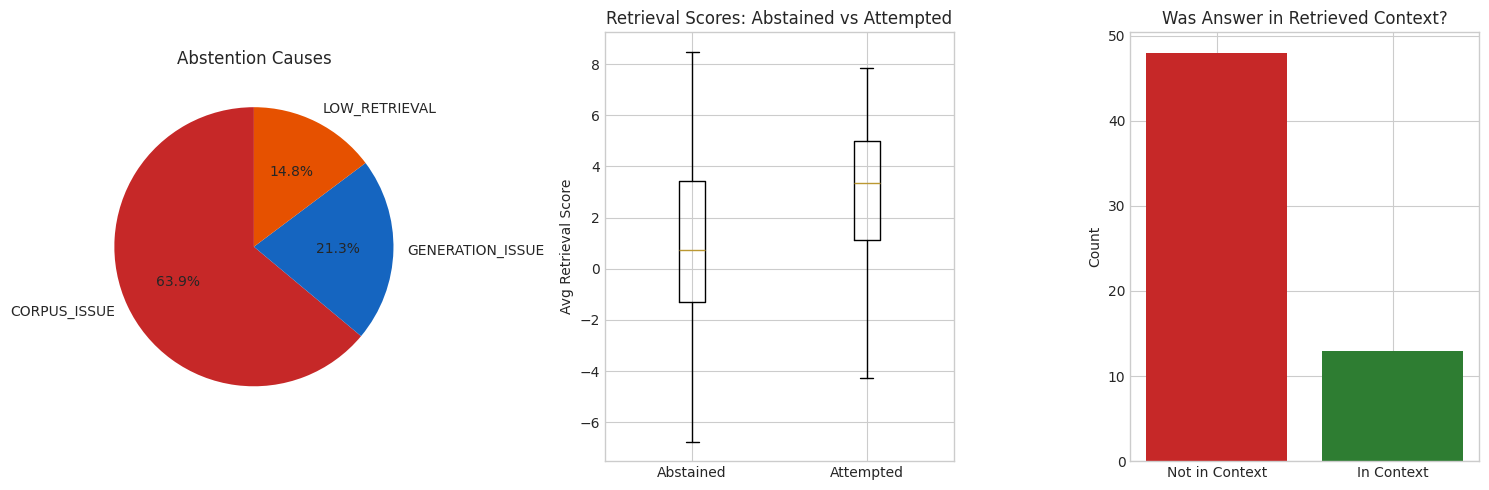

In [160]:
# Visualize abstention causes
if 'abstention_analysis' in dir() and abstention_analysis is not None and len(abstention_analysis) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Issue type distribution (pie chart)
    ax1 = axes[0]
    issue_counts = abstention_analysis['issue_type'].value_counts()
    colors = {'CORPUS_ISSUE': '#c62828', 'LOW_RETRIEVAL': '#e65100', 
              'GENERATION_ISSUE': '#1565c0', 'NO_DOCS': '#6a1b9a'}
    pie_colors = [colors.get(x, 'gray') for x in issue_counts.index]
    ax1.pie(issue_counts.values, labels=issue_counts.index, autopct='%1.1f%%', 
            colors=pie_colors, startangle=90)
    ax1.set_title('Abstention Causes')
    
    # 2. Retrieval scores for abstention vs non-abstention
    ax2 = axes[1]
    if 'retrieval_analysis' in dir() and retrieval_analysis is not None:
        abstained_scores = abstention_analysis['avg_retrieval_score']
        attempted_scores = retrieval_analysis[retrieval_analysis['idx'].isin(attempted_df['idx'])]['avg_retrieval_score']
        
        ax2.boxplot([abstained_scores, attempted_scores], labels=['Abstained', 'Attempted'])
        ax2.set_ylabel('Avg Retrieval Score')
        ax2.set_title('Retrieval Scores: Abstained vs Attempted')
    
    # 3. Answer in context rate
    ax3 = axes[2]
    answer_in_ctx = abstention_analysis['answer_in_context'].value_counts()
    ax3.bar(['Not in Context', 'In Context'], 
            [answer_in_ctx.get(False, 0), answer_in_ctx.get(True, 0)],
            color=['#c62828', '#2e7d32'])
    ax3.set_ylabel('Count')
    ax3.set_title('Was Answer in Retrieved Context?')
    
    plt.tight_layout()
    plt.show()

#### Example Abstention Cases by Issue Type

Let's look at examples from each issue type to understand what's happening.

In [161]:
def display_abstention_example(row: pd.Series, abstained_df_full: pd.DataFrame):
    """Display a detailed view of an abstention case."""
    # Get the full row with retrieved docs
    full_row = abstained_df_full[abstained_df_full['idx'] == row['idx']].iloc[0]
    docs = full_row.get('retrieved_docs', [])
    
    expected_str = ", ".join(row['expected']) if isinstance(row['expected'], list) else str(row['expected'])
    
    # Format retrieved docs
    docs_html = ""
    if docs:
        docs_html = "<div style='background-color:#f5f5f5; padding:10px; margin:5px 0; border-radius:5px;'>"
        docs_html += "<strong>Retrieved Context:</strong><br>"
        for doc in docs[:3]:  # Show top 3
            score = doc.get('score', 0)
            content = doc.get('content', '')[:400]
            if len(doc.get('content', '')) > 400:
                content += "..."
            docs_html += f"<div style='margin:5px 0; padding:5px; border-left:3px solid #1976d2;'>"
            docs_html += f"<small>[Score: {score:.4f}]</small><br>"
            docs_html += f"<code style='white-space:pre-wrap; font-size:0.85em;'>{content}</code></div>"
        docs_html += "</div>"
    
    # Issue type color
    issue_colors = {
        'CORPUS_ISSUE': '#c62828',
        'LOW_RETRIEVAL': '#e65100', 
        'GENERATION_ISSUE': '#1565c0',
        'NO_DOCS': '#6a1b9a'
    }
    color = issue_colors.get(row['issue_type'], 'gray')
    
    html = f"""
    <div style='border:2px solid {color}; padding:15px; margin:10px 0; border-radius:10px;'>
        <div style='display:flex; justify-content:space-between; align-items:center;'>
            <span style='font-size:1.1em; font-weight:bold;'>Question #{row['idx']}</span>
            <span style='background-color:{color}; color:white; padding:5px 10px; border-radius:5px;'>{row['issue_type']}</span>
        </div>
        
        <div style='margin:10px 0;'>
            <strong>Question:</strong> {row['question']}
        </div>
        
        <div style='padding:8px; background-color:#e8f5e9; border-radius:5px; margin:10px 0;'>
            <strong>Expected:</strong> {expected_str}
        </div>
        
        <div style='display:grid; grid-template-columns:1fr 1fr; gap:10px;'>
            <div style='padding:10px; background-color:#fff3e0; border-radius:5px;'>
                <strong>Direct LLM</strong> (F1: {row['direct_f1']:.2f})<br>
                <em>{row['direct_answer'][:200]}{'...' if len(str(row['direct_answer'])) > 200 else ''}</em>
            </div>
            <div style='padding:10px; background-color:#ffebee; border-radius:5px;'>
                <strong>RAG (Abstained)</strong><br>
                <em>{row['rag_answer'][:200]}{'...' if len(str(row['rag_answer'])) > 200 else ''}</em>
            </div>
        </div>
        
        <div style='margin-top:10px; padding:5px; background-color:#e3f2fd; border-radius:5px;'>
            <small>
                Retrieval Score: {row['max_retrieval_score']:.4f} | 
                Answer in Context: {'Yes' if row['answer_in_context'] else 'No'} |
                Direct Correct: {'Yes' if row['direct_correct'] else 'No'}
            </small>
        </div>
        
        {docs_html}
    </div>
    """
    display(HTML(html))

# Show examples for each issue type
if 'abstention_analysis' in dir() and abstention_analysis is not None and len(abstention_analysis) > 0:
    issue_types = abstention_analysis['issue_type'].unique()
    
    for issue_type in issue_types:
        issue_cases = abstention_analysis[abstention_analysis['issue_type'] == issue_type]
        print(f"\n{'='*60}")
        print(f"Issue Type: {issue_type} ({len(issue_cases)} cases)")
        print(f"{'='*60}")
        
        # Show up to 2 examples per issue type
        for _, row in issue_cases.head(2).iterrows():
            display_abstention_example(row, abstained_df)


Issue Type: CORPUS_ISSUE (39 cases)



Issue Type: GENERATION_ISSUE (13 cases)



Issue Type: LOW_RETRIEVAL (9 cases)


#### Summary: RAG Parameters vs Corpus Quality

Based on the abstention analysis, here's how to diagnose your RAG system:

In [162]:
def print_diagnosis(abstention_analysis: pd.DataFrame):
    """Print diagnostic summary based on abstention analysis."""
    if abstention_analysis is None or len(abstention_analysis) == 0:
        print("No abstention cases to diagnose.")
        return
    
    issue_counts = abstention_analysis['issue_type'].value_counts()
    total = len(abstention_analysis)
    
    print("=" * 70)
    print("DIAGNOSIS: What's Causing RAG Failures?")
    print("=" * 70)
    
    # Calculate percentages
    corpus_pct = issue_counts.get('CORPUS_ISSUE', 0) / total * 100 if total > 0 else 0
    retrieval_pct = issue_counts.get('LOW_RETRIEVAL', 0) / total * 100 if total > 0 else 0
    generation_pct = issue_counts.get('GENERATION_ISSUE', 0) / total * 100 if total > 0 else 0
    
    print(f"\nOf {total} abstention cases:")
    print(f"  - {corpus_pct:.1f}% = CORPUS ISSUE (documents don't contain the answer)")
    print(f"  - {retrieval_pct:.1f}% = RETRIEVAL ISSUE (poor retrieval scores)")
    print(f"  - {generation_pct:.1f}% = GENERATION ISSUE (answer in context but model failed)")
    
    print("\n" + "-" * 70)
    print("RECOMMENDATIONS:")
    print("-" * 70)
    
    if corpus_pct > 40:
        print("\n  CORPUS QUALITY IS THE MAIN ISSUE")
        print("  - Your document index is missing relevant information")
        print("  - Consider: Adding more documents, better chunking, metadata enrichment")
    
    if retrieval_pct > 30:
        print("\n  RETRIEVAL PARAMETERS NEED TUNING")
        print("  - Retrieved documents have low relevance scores")
        print("  - Consider: Different embedding model, hybrid search, query expansion (HyDE)")
        print("  - Try: Increasing top_k, using reranking, multiquery retrieval")
    
    if generation_pct > 20:
        print("\n  GENERATION/PROMPT NEEDS IMPROVEMENT")
        print("  - The context contains the answer but the model isn't using it")
        print("  - Consider: Better prompting, different prompt style, model fine-tuning")
        print("  - Check: Is the context too long? Is the answer buried in noise?")
    
    # Overall assessment
    if corpus_pct > retrieval_pct and corpus_pct > generation_pct:
        primary = "CORPUS QUALITY"
    elif retrieval_pct > corpus_pct and retrieval_pct > generation_pct:
        primary = "RETRIEVAL PARAMETERS"
    else:
        primary = "GENERATION/PROMPTING"
    
    print(f"\n  PRIMARY FOCUS AREA: {primary}")

if 'abstention_analysis' in dir() and abstention_analysis is not None:
    print_diagnosis(abstention_analysis)

DIAGNOSIS: What's Causing RAG Failures?

Of 61 abstention cases:
  - 63.9% = CORPUS ISSUE (documents don't contain the answer)
  - 14.8% = RETRIEVAL ISSUE (poor retrieval scores)
  - 21.3% = GENERATION ISSUE (answer in context but model failed)

----------------------------------------------------------------------
RECOMMENDATIONS:
----------------------------------------------------------------------

  CORPUS QUALITY IS THE MAIN ISSUE
  - Your document index is missing relevant information
  - Consider: Adding more documents, better chunking, metadata enrichment

  GENERATION/PROMPT NEEDS IMPROVEMENT
  - The context contains the answer but the model isn't using it
  - Consider: Better prompting, different prompt style, model fine-tuning
  - Check: Is the context too long? Is the answer buried in noise?

  PRIMARY FOCUS AREA: CORPUS QUALITY


In [163]:
def full_abstention_analysis(
    rag_exp_name: str = None,
    model: str = 'Llama-3.2-3B',
    dataset: str = 'nq',
):
    """
    Complete abstention analysis for any RAG experiment.
    
    This function:
    1. Loads the comparison between RAG and direct LLM
    2. Identifies abstention responses
    3. Analyzes root causes
    4. Prints diagnostic recommendations
    
    Returns the analysis DataFrames for further exploration.
    """
    # Find direct baseline
    direct_exp = direct_baselines.get((model, dataset))
    if not direct_exp:
        print(f"No direct baseline found for {model} on {dataset}")
        return None
    
    # Find RAG experiment
    if rag_exp_name is None:
        matching = rag_with_baseline[
            (rag_with_baseline['model'] == model) & 
            (rag_with_baseline['dataset'] == dataset)
        ]
        if len(matching) == 0:
            print(f"No RAG experiments found for {model} on {dataset}")
            return None
        rag_exp_name = matching.iloc[0]['name']
    
    print(f"Analyzing: {rag_exp_name}")
    print(f"vs Direct: {direct_exp}\n")
    
    # Load comparison
    comp = compare_rag_vs_direct(rag_exp_name, direct_exp, STUDY_PATH, metric='f1')
    if comp is None:
        return None
    
    # Run abstention analysis
    comp_flags, attempted, abstained = analyze_with_abstention_filter(comp)
    
    if len(abstained) == 0:
        print("No abstention cases found!")
        return {'comparison': comp, 'attempted': attempted, 'abstained': abstained}
    
    # Analyze causes
    analysis = analyze_abstention_causes(abstained)
    
    # Print diagnosis
    print_diagnosis(analysis)
    
    return {
        'comparison': comp_flags,
        'attempted': attempted,
        'abstained': abstained,
        'abstention_analysis': analysis
    }

# Example usage:
print("Use full_abstention_analysis() to analyze any experiment:")
print("  result = full_abstention_analysis(model='Llama-3.2-3B', dataset='nq')")
print("  result = full_abstention_analysis(rag_exp_name='your_exp_name')")

Use full_abstention_analysis() to analyze any experiment:
  result = full_abstention_analysis(model='Llama-3.2-3B', dataset='nq')
  result = full_abstention_analysis(rag_exp_name='your_exp_name')


### 10.10 Direct Hit Analysis: Where Direct LLM Beats RAG

The key question: **How often does the Direct LLM answer correctly when RAG fails?**

This helps understand if RAG is actually hurting performance by:
1. Adding noise/confusion from irrelevant context
2. Causing the model to abstain when it actually knew the answer

In [164]:
# Find the BEST RAG config per model/dataset
best_rag_configs = rag_with_baseline.loc[
    rag_with_baseline.groupby(['model', 'dataset'])['f1'].idxmax()
][['name', 'model', 'dataset', 'f1', 'exact_match']]

# Find the Direct LLM configs
direct_configs = df[df['exp_type'] == 'direct'][['name', 'model', 'dataset', 'f1', 'exact_match']]

print("=== BEST RAG Configurations ===")
display(best_rag_configs)

print("\n=== Direct LLM Baselines ===")
display(direct_configs)

=== BEST RAG Configurations ===


,name,model,dataset,f1,exact_match
264,rag_hf_google_gemma2bit_dense_e5_large_k5_conc...,Gemma-2B,hotpotqa,0.064310,0.02
271,rag_hf_google_gemma2bit_hybrid_bge_k5_hyde_rer...,Gemma-2B,nq,0.133620,0.07
92,rag_hf_metallama_Llama3.23BInstruct_dense_bge_...,Llama-3.2-3B,hotpotqa,0.129452,0.09
235,rag_hf_metallama_Llama3.23BInstruct_hybrid_bge...,Llama-3.2-3B,nq,0.240424,0.15
287,rag_hf_Qwen_Qwen2.51.5BInstruct_hybrid_bge_den...,Qwen-1.5B,hotpotqa,0.041386,0.02
237,rag_hf_Qwen_Qwen2.51.5BInstruct_dense_e5_large...,Qwen-1.5B,nq,0.039244,0.02



=== Direct LLM Baselines ===


,name,model,dataset,f1,exact_match
22,direct_hf_google_gemma2bit_concise_hotpotqa_none,Gemma-2B,hotpotqa,0.050939,0.00
27,direct_hf_metallama_Llama3.23BInstruct_concise...,Llama-3.2-3B,nq,0.267985,0.17
71,direct_hf_google_gemma2bit_concise_nq_none,Gemma-2B,nq,0.057504,0.01
72,direct_hf_metallama_Llama3.23BInstruct_concise...,Llama-3.2-3B,hotpotqa,0.164044,0.12
175,direct_hf_Qwen_Qwen2.51.5BInstruct_concise_hot...,Qwen-1.5B,hotpotqa,0.107689,0.04


In [165]:
def analyze_direct_wins(model: str, dataset: str, f1_threshold: float = 0.5):
    """
    Analyze questions where Direct LLM got it right but RAG got it wrong.
    
    Args:
        model: Model to analyze
        dataset: Dataset to analyze
        f1_threshold: Threshold to consider an answer "correct" (default 0.5)
    
    Returns:
        DataFrame with analysis results
    """
    # Get best RAG config for this model/dataset
    best_rag = best_rag_configs[
        (best_rag_configs['model'] == model) & 
        (best_rag_configs['dataset'] == dataset)
    ]
    
    if len(best_rag) == 0:
        print(f"No RAG config found for {model} on {dataset}")
        return None
    
    best_rag_name = best_rag.iloc[0]['name']
    
    # Get direct baseline
    direct_name = direct_baselines.get((model, dataset))
    if not direct_name:
        print(f"No direct baseline found for {model} on {dataset}")
        return None
    
    print(f"Model: {model}, Dataset: {dataset}")
    print(f"Best RAG: {best_rag_name}")
    print(f"Direct:   {direct_name}")
    print(f"F1 Threshold for 'correct': {f1_threshold}")
    print("-" * 70)
    
    # Load predictions
    comp = compare_rag_vs_direct(best_rag_name, direct_name, STUDY_PATH, metric='f1')
    if comp is None:
        return None
    
    # Categorize each question
    comp['direct_correct'] = comp['direct_f1'] >= f1_threshold
    comp['rag_correct'] = comp['rag_f1'] >= f1_threshold
    
    # Key categories
    both_correct = ((comp['direct_correct']) & (comp['rag_correct'])).sum()
    both_wrong = ((~comp['direct_correct']) & (~comp['rag_correct'])).sum()
    direct_wins = ((comp['direct_correct']) & (~comp['rag_correct'])).sum()  # Direct got it, RAG missed
    rag_wins = ((~comp['direct_correct']) & (comp['rag_correct'])).sum()  # RAG got it, Direct missed
    
    total = len(comp)
    
    # Display summary
    html = f"""
    <div style='background-color:#263238; color:white; padding:20px; border-radius:10px; margin:10px 0;'>
        <h3 style='margin:0 0 15px 0;'>Question-Level Comparison: Best RAG vs Direct LLM</h3>
        <div style='display:grid; grid-template-columns:repeat(4, 1fr); gap:15px;'>
            <div style='text-align:center; padding:15px; background-color:#2e7d32; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{both_correct}</div>
                <div>Both Correct ({both_correct/total*100:.1f}%)</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#1565c0; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{rag_wins}</div>
                <div>RAG Wins ({rag_wins/total*100:.1f}%)</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#c62828; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{direct_wins}</div>
                <div>Direct Wins ({direct_wins/total*100:.1f}%)</div>
            </div>
            <div style='text-align:center; padding:15px; background-color:#455a64; border-radius:8px;'>
                <div style='font-size:2em; font-weight:bold;'>{both_wrong}</div>
                <div>Both Wrong ({both_wrong/total*100:.1f}%)</div>
            </div>
        </div>
        <div style='margin-top:15px; text-align:center; font-size:1.1em;'>
            <strong>Net RAG Benefit: {rag_wins - direct_wins:+d} questions</strong>
            ({(rag_wins - direct_wins)/total*100:+.1f}% of total)
        </div>
    </div>
    """
    display(HTML(html))
    
    # Add categories to dataframe
    comp['category'] = 'both_wrong'
    comp.loc[(comp['direct_correct']) & (comp['rag_correct']), 'category'] = 'both_correct'
    comp.loc[(comp['direct_correct']) & (~comp['rag_correct']), 'category'] = 'direct_wins'
    comp.loc[(~comp['direct_correct']) & (comp['rag_correct']), 'category'] = 'rag_wins'
    
    return comp

# Analyze for each model/dataset combo
print("=" * 70)
print("DIRECT WINS ANALYSIS: Where Direct LLM Beats Best RAG")
print("=" * 70)

DIRECT WINS ANALYSIS: Where Direct LLM Beats Best RAG


In [166]:
# Run analysis for all model/dataset combinations
all_analyses = {}

for (model, dataset), direct_exp in direct_baselines.items():
    print(f"\n{'='*70}")
    result = analyze_direct_wins(model, dataset, f1_threshold=0.5)
    if result is not None:
        all_analyses[(model, dataset)] = result


Model: Gemma-2B, Dataset: hotpotqa
Best RAG: rag_hf_google_gemma2bit_dense_e5_large_k5_concise_hotpotqa_none
Direct:   direct_hf_google_gemma2bit_concise_hotpotqa_none
F1 Threshold for 'correct': 0.5
----------------------------------------------------------------------



Model: Llama-3.2-3B, Dataset: nq
Best RAG: rag_hf_metallama_Llama3.23BInstruct_hybrid_bge_k3_hyde_rerank_ms_marco_fewshot_3_nq_none
Direct:   direct_hf_metallama_Llama3.23BInstruct_concise_nq_none
F1 Threshold for 'correct': 0.5
----------------------------------------------------------------------



Model: Gemma-2B, Dataset: nq
Best RAG: rag_hf_google_gemma2bit_hybrid_bge_k5_hyde_rerank_ms_marco_fewshot_3_nq_none
Direct:   direct_hf_google_gemma2bit_concise_nq_none
F1 Threshold for 'correct': 0.5
----------------------------------------------------------------------



Model: Llama-3.2-3B, Dataset: hotpotqa
Best RAG: rag_hf_metallama_Llama3.23BInstruct_dense_bge_large_k5_concise_hotpotqa_none
Direct:   direct_hf_metallama_Llama3.23BInstruct_concise_hotpotqa_none
F1 Threshold for 'correct': 0.5
----------------------------------------------------------------------



Model: Qwen-1.5B, Dataset: hotpotqa
Best RAG: rag_hf_Qwen_Qwen2.51.5BInstruct_hybrid_bge_dense_heavy_k5_concise_hotpotqa_none
Direct:   direct_hf_Qwen_Qwen2.51.5BInstruct_concise_hotpotqa_none
F1 Threshold for 'correct': 0.5
----------------------------------------------------------------------



Model: Qwen-1.5B, Dataset: nq
Best RAG: rag_hf_Qwen_Qwen2.51.5BInstruct_dense_e5_large_k3_concise_nq_none
Direct:   direct_hf_Qwen_Qwen2.51.5BInstruct_concise_nq_none
F1 Threshold for 'correct': 0.5
----------------------------------------------------------------------


#### Examining "Direct Wins" Cases

These are the critical cases where RAG actually hurt - the model knew the answer without context, but failed when given retrieved documents.

In [167]:
# Pick one model/dataset to examine in detail
# Using Llama as it's typically the best performing
EXAMINE_MODEL = 'Llama-3.2-3B'
EXAMINE_DATASET = 'nq'

if (EXAMINE_MODEL, EXAMINE_DATASET) in all_analyses:
    analysis_df = all_analyses[(EXAMINE_MODEL, EXAMINE_DATASET)]
    
    # Get direct wins cases
    direct_wins_df = analysis_df[analysis_df['category'] == 'direct_wins'].sort_values('direct_f1', ascending=False)
    
    print(f"Found {len(direct_wins_df)} questions where Direct LLM succeeded but RAG failed")
    print(f"Model: {EXAMINE_MODEL}, Dataset: {EXAMINE_DATASET}")
    print("\nShowing top 5 cases:\n")
    
    for i, (_, row) in enumerate(direct_wins_df.head(5).iterrows()):
        display_comparison(row)
else:
    print(f"No analysis available for {EXAMINE_MODEL} on {EXAMINE_DATASET}")

Found 14 questions where Direct LLM succeeded but RAG failed
Model: Llama-3.2-3B, Dataset: nq

Showing top 5 cases:



In [168]:
# Analyze WHY direct wins - was RAG abstaining or giving wrong answers?
if (EXAMINE_MODEL, EXAMINE_DATASET) in all_analyses:
    analysis_df = all_analyses[(EXAMINE_MODEL, EXAMINE_DATASET)]
    direct_wins_df = analysis_df[analysis_df['category'] == 'direct_wins'].copy()
    
    if len(direct_wins_df) > 0:
        # Check if RAG abstained or gave wrong answer
        direct_wins_df['rag_abstained'] = direct_wins_df['rag_answer'].apply(is_abstention_response)
        
        abstained = direct_wins_df['rag_abstained'].sum()
        wrong_answer = (~direct_wins_df['rag_abstained']).sum()
        
        print("=" * 70)
        print("WHY DID RAG FAIL IN 'DIRECT WINS' CASES?")
        print("=" * 70)
        print(f"\nTotal 'Direct Wins' cases: {len(direct_wins_df)}")
        print(f"  - RAG Abstained ('Unknown', etc.): {abstained} ({abstained/len(direct_wins_df)*100:.1f}%)")
        print(f"  - RAG Gave Wrong Answer: {wrong_answer} ({wrong_answer/len(direct_wins_df)*100:.1f}%)")
        
        # For abstention cases, check retrieval quality
        abstained_cases = direct_wins_df[direct_wins_df['rag_abstained']]
        wrong_cases = direct_wins_df[~direct_wins_df['rag_abstained']]
        
        if len(abstained_cases) > 0:
            # Check if answer was in context for abstention cases
            answer_in_context = 0
            for _, row in abstained_cases.iterrows():
                docs = row.get('retrieved_docs', [])
                expected = row['expected']
                if isinstance(expected, str):
                    expected = [expected]
                all_content = " ".join([d.get('content', '').lower() for d in docs]) if docs else ""
                if any(exp.lower() in all_content for exp in expected):
                    answer_in_context += 1
            
            print(f"\n  In abstention cases:")
            print(f"    - Answer was in retrieved context: {answer_in_context} ({answer_in_context/len(abstained_cases)*100:.1f}%)")
            print(f"    - Answer NOT in context: {len(abstained_cases) - answer_in_context} ({(len(abstained_cases) - answer_in_context)/len(abstained_cases)*100:.1f}%)")
    else:
        print("No 'Direct Wins' cases found - RAG is not hurting performance!")

WHY DID RAG FAIL IN 'DIRECT WINS' CASES?

Total 'Direct Wins' cases: 14
  - RAG Abstained ('Unknown', etc.): 6 (42.9%)
  - RAG Gave Wrong Answer: 8 (57.1%)

  In abstention cases:
    - Answer was in retrieved context: 2 (33.3%)
    - Answer NOT in context: 4 (66.7%)


In [169]:
# Summary table across all model/dataset combinations
summary_rows = []

for (model, dataset), analysis_df in all_analyses.items():
    total = len(analysis_df)
    both_correct = (analysis_df['category'] == 'both_correct').sum()
    rag_wins = (analysis_df['category'] == 'rag_wins').sum()
    direct_wins = (analysis_df['category'] == 'direct_wins').sum()
    both_wrong = (analysis_df['category'] == 'both_wrong').sum()
    
    summary_rows.append({
        'Model': model,
        'Dataset': dataset,
        'Total': total,
        'Both Correct': both_correct,
        'RAG Wins': rag_wins,
        'Direct Wins': direct_wins,
        'Both Wrong': both_wrong,
        'Net RAG Benefit': rag_wins - direct_wins,
        'RAG Win Rate': f"{rag_wins/total*100:.1f}%",
        'Direct Win Rate': f"{direct_wins/total*100:.1f}%",
    })

summary_df = pd.DataFrame(summary_rows)

print("=" * 70)
print("SUMMARY: Best RAG vs Direct LLM Across All Models/Datasets")
print("=" * 70)
print("\n(All comparisons use F1 threshold of 0.5 to define 'correct')\n")
display(summary_df)

SUMMARY: Best RAG vs Direct LLM Across All Models/Datasets

(All comparisons use F1 threshold of 0.5 to define 'correct')



,Model,Dataset,Total,Both Correct,RAG Wins,Direct Wins,Both Wrong,Net RAG Benefit,RAG Win Rate,Direct Win Rate
0,Gemma-2B,hotpotqa,100,0,3,4,93,-1,3.0%,4.0%
1,Llama-3.2-3B,nq,100,13,11,14,62,-3,11.0%,14.0%
2,Gemma-2B,nq,100,1,14,1,84,13,14.0%,1.0%
3,Llama-3.2-3B,hotpotqa,100,6,7,12,75,-5,7.0%,12.0%
4,Qwen-1.5B,hotpotqa,100,1,2,9,88,-7,2.0%,9.0%
5,Qwen-1.5B,nq,100,0,3,0,97,3,3.0%,0.0%


#### Key Takeaways from Direct Wins Analysis

**Interpreting the Results:**

- **RAG Wins > Direct Wins**: RAG is helping - it's finding useful context
- **Direct Wins > RAG Wins**: RAG is hurting - the context is confusing the model
- **Net RAG Benefit**: The difference tells you if RAG is worth using

**When Direct Wins (RAG Hurts):**

1. **RAG Abstained + Answer NOT in Context**: Corpus/index issue - documents missing
2. **RAG Abstained + Answer IN Context**: Generation issue - model not using context well
3. **RAG Gave Wrong Answer**: Misleading context - retrieved docs are confusing the model

**Actions Based on Results:**

- High "Direct Wins" from abstention → Improve retrieval or add documents
- High "Direct Wins" from wrong answers → Retrieved context is misleading, try better reranking


=== Feature Importance for F1 Improvement ===
           feature  importance
6     prompt_style    0.000000
4  query_transform    0.013588
3            top_k    0.015901
2   retriever_name    0.017354
5         reranker    0.019328
1   retriever_type    0.036097
7          dataset    0.098290
0            model    0.799443


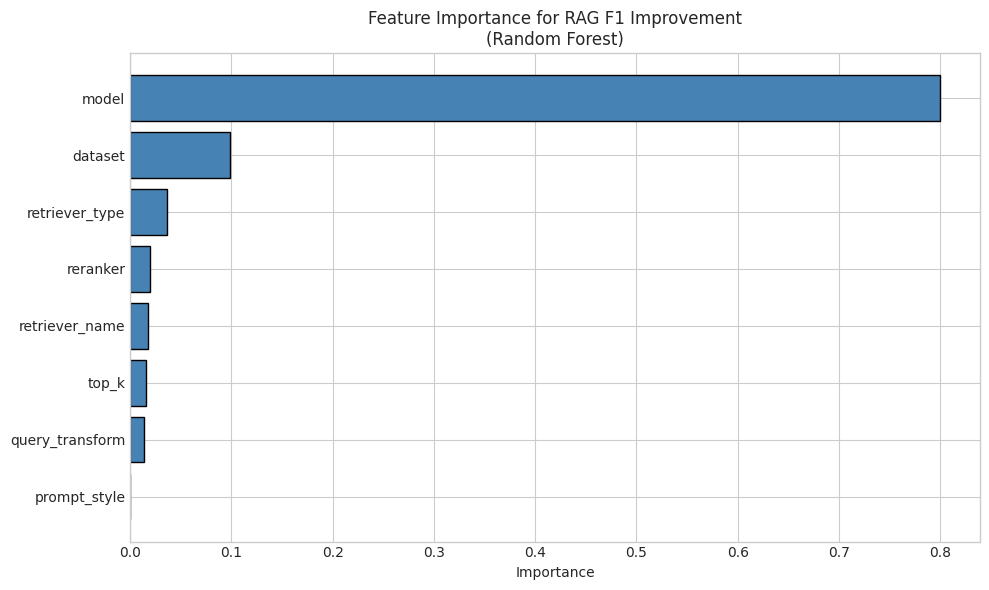

In [170]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_encoded, y)

# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

print("\n=== Feature Importance for F1 Improvement ===")
print(importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance for RAG F1 Improvement\n(Random Forest)')
plt.tight_layout()
plt.show()

## 7. Statistical Tests

Let's verify if the differences are statistically significant.

In [171]:
from scipy import stats

# Test: Does RAG significantly improve over baseline?
t_stat, p_value = stats.ttest_1samp(rag_with_baseline['f1_improvement'].dropna(), 0)
print(f"\n=== T-test: RAG improvement significantly different from 0? ===")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Significant at 0.05: {p_value < 0.05}")


=== T-test: RAG improvement significantly different from 0? ===
t-statistic: -13.0496
p-value: 0.000000
Significant at 0.05: True


In [172]:
# Test: Is there a significant difference between query transforms?
groups = [group['f1_improvement'].values for name, group in rag_with_baseline.groupby('query_transform')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\n=== ANOVA: Query Transform effect ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Significant at 0.05: {p_value < 0.05}")


=== ANOVA: Query Transform effect ===
F-statistic: nan
p-value: nan
Significant at 0.05: False


In [173]:
# Test: Is there a significant difference between rerankers?
groups = [group['f1_improvement'].values for name, group in rag_with_baseline.groupby('reranker')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\n=== ANOVA: Reranker effect ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Significant at 0.05: {p_value < 0.05}")


=== ANOVA: Reranker effect ===
F-statistic: nan
p-value: nan
Significant at 0.05: False


## 8. Key Insights Summary

In [174]:
print("="*70)
print("KEY INSIGHTS FROM RAG STRATEGY ANALYSIS")
print("="*70)

# Overall RAG impact
print(f"\n1. OVERALL RAG IMPACT")
print(f"   - RAG improves in {(rag_with_baseline['f1_improvement'] > 0).mean()*100:.1f}% of configurations")
print(f"   - Average F1 improvement: {rag_with_baseline['f1_improvement'].mean():.4f}")
print(f"   - Best improvement: +{rag_with_baseline['f1_improvement'].max():.4f}")
print(f"   - Worst degradation: {rag_with_baseline['f1_improvement'].min():.4f}")

# Best components
print(f"\n2. BEST COMPONENTS")
best_qt = rag_with_baseline.groupby('query_transform')['f1_improvement'].mean().idxmax()
best_rr = rag_with_baseline.groupby('reranker')['f1_improvement'].mean().idxmax()
best_rt = rag_with_baseline.groupby('retriever_type')['f1_improvement'].mean().idxmax()
best_k = rag_with_baseline.groupby('top_k')['f1_improvement'].mean().idxmax()

print(f"   - Best query transform: {best_qt}")
print(f"   - Best reranker: {best_rr}")
print(f"   - Best retriever type: {best_rt}")
print(f"   - Best top_k: {best_k}")

# Model-specific insights
print(f"\n3. MODEL-SPECIFIC INSIGHTS")
for model in rag_with_baseline['model'].dropna().unique():
    model_data = rag_with_baseline[rag_with_baseline['model'] == model]
    avg_imp = model_data['f1_improvement'].mean()
    best_config = model_data.loc[model_data['f1_improvement'].idxmax()]
    print(f"   {model}:")
    print(f"      - Avg improvement: {avg_imp:.4f}")
    print(f"      - Best config: {best_config['retriever_type']}, k={best_config['top_k']}, "
          f"{best_config['query_transform']}, {best_config['reranker']}")
    print(f"      - Best improvement: +{best_config['f1_improvement']:.4f}")

print("\n" + "="*70)

KEY INSIGHTS FROM RAG STRATEGY ANALYSIS

1. OVERALL RAG IMPACT
   - RAG improves in 14.8% of configurations
   - Average F1 improvement: -0.0723
   - Best improvement: +0.0432
   - Worst degradation: -0.2394

2. BEST COMPONENTS
   - Best query transform: none
   - Best reranker: none
   - Best retriever type: hybrid
   - Best top_k: 3.0

3. MODEL-SPECIFIC INSIGHTS
   Llama-3.2-3B:
      - Avg improvement: -0.1479
      - Best config: dense, k=5.0, none, none
      - Best improvement: +-0.0346
   Gemma-2B:
      - Avg improvement: 0.0004
      - Best config: hybrid, k=5.0, hyde, ms_marco
      - Best improvement: +0.0432
   Qwen-1.5B:
      - Avg improvement: -0.0865
      - Best config: hybrid, k=5.0, none, none
      - Best improvement: +-0.0663



## 9. Recommendations

In [175]:
print("="*70)
print("RECOMMENDATIONS FOR OPTIMAL RAG CONFIGURATION")
print("="*70)

# Find most consistently good configurations
config_cols = ['retriever_type', 'top_k', 'query_transform', 'reranker']
config_perf = rag_with_baseline.groupby(config_cols).agg({
    'f1_improvement': ['mean', 'std', 'count']
}).reset_index()
config_perf.columns = config_cols + ['mean_improvement', 'std_improvement', 'count']

# Filter to configs with enough samples
config_perf = config_perf[config_perf['count'] >= 2]

# Score: mean improvement with penalty for variance
config_perf['score'] = config_perf['mean_improvement'] - 0.5 * config_perf['std_improvement']

best_configs = config_perf.nlargest(5, 'score')

print("\nTOP 5 RECOMMENDED CONFIGURATIONS (balancing performance and consistency):")
print("-" * 70)
for i, row in best_configs.iterrows():
    print(f"\n  Config {best_configs.index.get_loc(i) + 1}:")
    print(f"    Retriever: {row['retriever_type']}")
    print(f"    Top-K: {row['top_k']}")
    print(f"    Query Transform: {row['query_transform']}")
    print(f"    Reranker: {row['reranker']}")
    print(f"    Avg Improvement: +{row['mean_improvement']:.4f} (±{row['std_improvement']:.4f})")

RECOMMENDATIONS FOR OPTIMAL RAG CONFIGURATION

TOP 5 RECOMMENDED CONFIGURATIONS (balancing performance and consistency):
----------------------------------------------------------------------

  Config 1:
    Retriever: dense
    Top-K: 3.0
    Query Transform: hyde
    Reranker: none
    Avg Improvement: +-0.0291 (±0.0761)

  Config 2:
    Retriever: hybrid
    Top-K: 3.0
    Query Transform: multiquery
    Reranker: bge
    Avg Improvement: +-0.0446 (±0.0593)

  Config 3:
    Retriever: hierarchical
    Top-K: 5.0
    Query Transform: none
    Reranker: none
    Avg Improvement: +-0.0327 (±0.0895)

  Config 4:
    Retriever: dense
    Top-K: 5.0
    Query Transform: multiquery
    Reranker: ms_marco
    Avg Improvement: +-0.0333 (±0.0922)

  Config 5:
    Retriever: hybrid
    Top-K: 10.0
    Query Transform: hyde
    Reranker: ms_marco
    Avg Improvement: +-0.0435 (±0.0774)
